# Make multiwavelength light curves using archival data
***

## Learning Goals    
By the end of this tutorial, you will be able to:
 - automatically load a catalog of sources
 - automatically search NASA and non-NASA resources for light curves
 - store light curves in a Pandas multiindex dataframe
 - plot all light curves on the same plot
 
 
## Introduction:
 - A user has a sample of interesting targets for which they would like to see a plot of available archival light curves.  We start with a small set of changing look AGN from Yang et al., 2018, which are automatically downloaded. Changing look AGN are cases where the broad emission lines appear or disappear (and not just that the flux is variable). 
 - We model light curve plots after van Velzen et al. 2021.  We search through a curated list of time-domain NASA holdings as well as non-NASA sources.  HEASARC catalogs used are Fermi and Beppo-Sax, IRSA catalogs used are ZTF and WISE, and MAST catalogs used are Pan-Starrs, TESS, Kepler, and K2.  Non-NASA sources are Gaia and IceCube. This list is generalized enough to include many types of targets to make this notebook interesting for many types of science.  All of these time-domain archives are searched in an automated fashion using astroquery or APIs.
 - Light curve data storage is a tricky problem.  Currently we are using a multi-index Pandas dataframe, as the best existing choice for right now.  One downside is that we need to manually track the units of flux and time instead of relying on an astropy storage scheme which would be able to do some of the units worrying for us (even astropy can't do all magnitude to flux conversions).  Astropy does not currently have a good option for multi-band light curve storage.
 - We intend to explore a ML classifier for these changing look AGN light curves.
 
## Input:
 - choose from a list of known changing look AGN from the literature
 
  OR - 
 - input your own sample

## Output:
 - an archival optical + IR + neutrino light curve
 
## Non-standard Imports:
- `astroquery` to interface with archives APIs
- `astropy` to work with coordinates/units and data structures
- `lightkurve` to search TESSS, Kepler, and K2 archives
- `urllib` to handle archive searches with website interface
- `acstools` to work with HST magnitude to flux conversion
- `unTimely` to retrieve WISE light curves
- `alerce` to convert ZTF object names into coordinates

## Authors:
Jessica Krick, Shoubaneh Hemmati, Andreas Faisst, Troy Raen, Brigitta Sipocz, Dave Shupe

## Acknowledgements:
Suvi Gezari, Antara Basu-zych,Stephanie LaMassa\
MAST, HEASARC, & IRSA Fornax teams



In [1]:
import numpy as np
import time
import pandas as pd
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import requests
import pickle
from math import ceil

from scipy import stats

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries

from multiprocessing import Pool

try:
    from tqdm import tqdm
except ImportError:
    !pip install tqdm
    from tqdm import tqdm

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try:
    import lightkurve as lk
except ImportError:
    !pip install lightkurve --upgrade
    import lightkurve as lk
        
try:
    from acstools import acszpt
except ImportError:
    !pip install acstools
    from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

try:
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
except ImportError:
    if not os.path.exists('./unTimely_Catalog_explorer'):
        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
    sys.path.append('./unTimely_Catalog_explorer')
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
    

!pip install alerce


import tempfile

# Local code imports
sys.path.append('code/')
from fluxconversions import convert_WISEtoJanskies, convertACSmagtoflux
from panstarrs import panstarrs_get_lightcurves, ps1cone, ps1search, checklegal, ps1metadata, addfilter, improve_filter_format, search_lightcurve
from clean_filternames import clean_filternames
from gaia_functions import Gaia_get_lightcurve, Gaia_extract_median_photometry, Gaia_retrieve_median_photometry, Gaia_retrieve_EPOCH_PHOTOMETRY, Gaia_mk_lightcurves, Gaia_mk_MultiIndex, Gaia_plot_lightcurves
from HCV_functions import get_hscapiurl, hcvcone, hcvsearch, hcvmetadata, cat2url, checklegal_hcv, HCV_get_lightcurves
from mast_functions import resolve, mastQuery
from icecube_functions import icecube_get_lightcurve, icecube_get_catalog, icecube_download_data
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,  get_SDSS_sample, remove_duplicate_coords
from ztf_functions import ZTF_id2coord,ZTF_get_lightcurve
from data_structures import MultiIndexDFObject
from heasarc_functions import HEASARC_get_lightcurves
from TESS_Kepler_functions import TESS_Kepler_get_lightcurves
from WISE_functions import WISE_get_lightcurves
from plot_settings import setup_text_plots

## NEW! LOAD/SAVE PICKLE FILE! ##
SAVEDF = False # if set to True, pickle file will be saved. If False, pickle file will be loaded.
pickle_file_name = "data/dflc_Shooby_March102023.pkl" # name of pickle file (to be loaded or saved)
#pickle_file_name = "data/dflc_Krick_Feb232023.pkl" # name of pickle file (to be loaded or saved)
###



/opt/conda/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/jkrick/.lightkurve/cache. Please move all the files in the legacy directory /home/jkrick/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [2]:
### Initialize Pandas MultiIndex data frame for storing the light curve
df_lc = MultiIndexDFObject()

## 1. Define the Sample
 We define here a "gold" sample of spectroscopically confirmed changing look AGN and quasars. This sample includes both objects which change from type 1 to type 2 and also the opposite.  Future studies may want to treat these as seperate objects or seperate QSOs from AGN.
 
 Bibcodes for the samples used are listed next to their functions for reference.  
 
 Functions used to grab the samples from the papers use Astroquery, NED, SIMBAD, Vizier, and in a few cases grab the tables from the html versions of the paper.

In [3]:
#build up the sample
coords =[]
labels = []

#choose your own adventure:

#get_lamassa_sample(coords, labels)  #2015ApJ...800..144L
#get_macleod16_sample(coords, labels) #2016MNRAS.457..389M
#get_ruan_sample(coords, labels) #2016ApJ...826..188R
#get_macleod19_sample(coords, labels)  #2019ApJ...874....8M
#get_sheng_sample(coords, labels)  #2020ApJ...889...46S
#get_green_sample(coords, labels)  #2022ApJ...933..180G
#get_lyu_sample(coords, labels)  #z32022ApJ...927..227L
#get_lopeznavas_sample(coords, labels)  #2022MNRAS.513L..57L
#get_hon_sample(coords, labels)  #2022MNRAS.511...54H
get_yang_sample(coords, labels)   #2018ApJ...862..109Y

#now get some "normal" QSOs for use in the classifier
#there are ~500K of these, so choose the number based on
#a balance between speed of running the light curves and whatever 
#the ML algorithms would like to have

num_normal_QSO = 100 
#get_SDSS_sample(coords, labels, num_normal_QSO)

#remove duplicates from the list if combining multiple references
coords_list, labels_list = remove_duplicate_coords(coords, labels)

#add an index-like list with our own object name
object_names = [['CLAGN' + str(i)] for i in range(len(coords_list))]
print('sample size: '+str(len(coords_list)))

## For testing
#coords_list = coords_list[0:4]
#labels_list = labels_list[0:4]
#object_names = object_names[0:4]

Changing Look AGN- Yang et al:  31
after duplicates removal, sample size: 30
sample size: 30


### 1.1 Build your own Sample

To build your own sample, you can follow the examples of functions above to grab coordinates from your favorite literature resource, 

or

You can use [astropy's read](https://docs.astropy.org/en/stable/io/ascii/read.html) function to read in an input table
and then convert that table into a list of [skycoords](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) 

## 2. Find light curves for these targets in NASA catalogs
  - We search a curated list of time-domain catalogs from all NASA astrophysics archives


In [4]:
def append_df_lc(archive_df_lc):
    """Append `archive_df_lc` to `df_lc`. When a `pool.apply_async` call completes, 
    this function will be called on the result (`archive_df_lc`).
    """
    try:
        df_lc.append(archive_df_lc.data)
    except AttributeError:
        # this archive call returned no data
        pass


### 2.1 HEASARC: FERMI & Beppo SAX


In [5]:
start_serial = time.time()
mission_list = ['FERMIGTRIG', 'SAXGRBMGRB']
radius = 0.1*u.degree

#go out and find all light curves in the above curated list which match our target positions
df_lc_heasarc = HEASARC_get_lightcurves(coords_list,labels_list,radius, mission_list)

append_df_lc(df_lc_heasarc)

100%|██████████| 30/30 [00:00<00:00, 54.25it/s]


### 2.2 IRSA: ZTF

In [23]:
df_lc_ZTF = ZTF_get_lightcurve(coords_list,labels_list,plotprint=0) ## number of plots to show to be set by plotprint

#add the resulting dataframe to all other archives
append_df_lc(df_lc_ZTF)

 43%|████▎     | 13/30 [05:23<07:03, 24.92s/it]


KeyboardInterrupt: 

### 2.3 IRSA:WISE

- use the unTimely catalog which ties together all WISE & NEOWISE 2010 - 2020 epochs.  Specifically it combined all observations at a single epoch to achieve deeper mag limits than individual observations alone.
- https://github.com/fkiwy/unTimely_Catalog_explorer
- https://iopscience-iop-org.caltech.idm.oclc.org/article/10.3847/1538-3881/aca2ab

In [7]:
bandlist = ['w1', 'w2']
WISE_radius = 1.0

df_lc_WISE = WISE_get_lightcurves(coords_list, labels_list, WISE_radius, bandlist)

#add the resulting dataframe to all other archives
append_df_lc(df_lc_WISE)

  0%|          | 0/30 [00:00<?, ?it/s]

Scanning catalog index file ...
Scanning individual catalog files ...
./000/0000p000/0000p000_w1_e000.cat.fits.gz
./000/0000p000/0000p000_w2_e000.cat.fits.gz
./000/0000p000/0000p000_w1_e001.cat.fits.gz
./000/0000p000/0000p000_w2_e001.cat.fits.gz
./000/0000p000/0000p000_w1_e002.cat.fits.gz
./000/0000p000/0000p000_w2_e002.cat.fits.gz
./000/0000p000/0000p000_w1_e003.cat.fits.gz
./000/0000p000/0000p000_w2_e003.cat.fits.gz
./000/0000p000/0000p000_w1_e004.cat.fits.gz
./000/0000p000/0000p000_w2_e004.cat.fits.gz
./000/0000p000/0000p000_w1_e005.cat.fits.gz
./000/0000p000/0000p000_w2_e005.cat.fits.gz
./000/0000p000/0000p000_w1_e006.cat.fits.gz
./000/0000p000/0000p000_w2_e006.cat.fits.gz
./000/0000p000/0000p000_w1_e007.cat.fits.gz
./000/0000p000/0000p000_w2_e007.cat.fits.gz
./000/0000p000/0000p000_w1_e008.cat.fits.gz
./000/0000p000/0000p000_w2_e008.cat.fits.gz
./000/0000p000/0000p000_w1_e009.cat.fits.gz
./000/0000p000/0000p000_w2_e009.cat.fits.gz
./000/0000p000/0000p000_w1_e010.cat.fits.gz
./000/

  3%|▎         | 1/30 [00:22<10:54, 22.56s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./021/0214m091/0214m091_w1_e000.cat.fits.gz
./021/0214m091/0214m091_w2_e000.cat.fits.gz
./021/0214m091/0214m091_w1_e001.cat.fits.gz
./021/0214m091/0214m091_w2_e001.cat.fits.gz
./021/0214m091/0214m091_w1_e002.cat.fits.gz
./021/0214m091/0214m091_w2_e002.cat.fits.gz
./021/0214m091/0214m091_w1_e003.cat.fits.gz
./021/0214m091/0214m091_w2_e003.cat.fits.gz
./021/0214m091/0214m091_w1_e004.cat.fits.gz
./021/0214m091/0214m091_w2_e004.cat.fits.gz
./021/0214m091/0214m091_w1_e005.cat.fits.gz
./021/0214m091/0214m091_w2_e005.cat.fits.gz
./021/0214m091/0214m091_w1_e006.cat.fits.gz
./021/0214m091/0214m091_w2_e006.cat.fits.gz
./021/0214m091/0214m091_w1_e007.cat.fits.gz
./021/0214m091/0214m091_w2_e007.cat.fits.gz
./021/0214m091/0214m091_w1_e008.cat.fits.gz
./021/0214m091/0214m091_w2_e008.cat.fits.gz
./021/0214m091/0214m091_w1_e009.cat.fits.gz
./021/0214m091/0214m091_w2_e009.cat.fits.gz
./021/0214m091/0214m091_w1_e010.cat.fits.gz
./021/

  7%|▋         | 2/30 [00:42<10:12, 21.89s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./030/0302p000/0302p000_w1_e000.cat.fits.gz
./030/0302p000/0302p000_w2_e000.cat.fits.gz
./030/0302p000/0302p000_w1_e001.cat.fits.gz
./030/0302p000/0302p000_w2_e001.cat.fits.gz
./030/0302p000/0302p000_w1_e002.cat.fits.gz
./030/0302p000/0302p000_w2_e002.cat.fits.gz
./030/0302p000/0302p000_w1_e003.cat.fits.gz
./030/0302p000/0302p000_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w1_e004.cat.fits.gz
./030/0302p000/0302p000_w2_e004.cat.fits.gz
./030/0302p000/0302p000_w1_e005.cat.fits.gz
./030/0302p000/0302p000_w2_e005.cat.fits.gz
./030/0302p000/0302p000_w1_e006.cat.fits.gz
./030/0302p000/0302p000_w2_e006.cat.fits.gz
./030/0302p000/0302p000_w1_e007.cat.fits.gz
./030/0302p000/0302p000_w2_e007.cat.fits.gz
./030/0302p000/0302p000_w1_e008.cat.fits.gz
./030/0302p000/0302p000_w2_e008.cat.fits.gz
./030/0302p000/0302p000_w1_e009.cat.fits.gz
./030/0302p000/0302p000_w2_e009.cat.fits.gz
./030/0302p000/0302p000_w1_e010.cat.fits.gz
./030/

 10%|█         | 3/30 [01:03<09:43, 21.62s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./121/1213p424/1213p424_w1_e000.cat.fits.gz
./121/1213p424/1213p424_w2_e000.cat.fits.gz
./121/1213p424/1213p424_w1_e001.cat.fits.gz
./121/1213p424/1213p424_w2_e001.cat.fits.gz
./121/1213p424/1213p424_w1_e002.cat.fits.gz
./121/1213p424/1213p424_w2_e002.cat.fits.gz
./121/1213p424/1213p424_w1_e003.cat.fits.gz
./121/1213p424/1213p424_w2_e003.cat.fits.gz
./121/1213p424/1213p424_w1_e004.cat.fits.gz
./121/1213p424/1213p424_w2_e004.cat.fits.gz
./121/1213p424/1213p424_w1_e005.cat.fits.gz
./121/1213p424/1213p424_w2_e005.cat.fits.gz
./121/1213p424/1213p424_w1_e006.cat.fits.gz
./121/1213p424/1213p424_w2_e006.cat.fits.gz
./121/1213p424/1213p424_w1_e007.cat.fits.gz
./121/1213p424/1213p424_w2_e007.cat.fits.gz
./121/1213p424/1213p424_w1_e008.cat.fits.gz
./121/1213p424/1213p424_w2_e008.cat.fits.gz
./121/1213p424/1213p424_w1_e009.cat.fits.gz
./121/1213p424/1213p424_w2_e009.cat.fits.gz
./121/1213p424/1213p424_w1_e010.cat.fits.gz
./121/

 13%|█▎        | 4/30 [01:25<09:20, 21.56s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./128/1287p363/1287p363_w1_e000.cat.fits.gz
./128/1287p363/1287p363_w2_e000.cat.fits.gz
./128/1287p363/1287p363_w1_e001.cat.fits.gz
./128/1287p363/1287p363_w2_e001.cat.fits.gz
./128/1287p363/1287p363_w1_e002.cat.fits.gz
./128/1287p363/1287p363_w2_e002.cat.fits.gz
./128/1287p363/1287p363_w1_e003.cat.fits.gz
./128/1287p363/1287p363_w2_e003.cat.fits.gz
./128/1287p363/1287p363_w1_e004.cat.fits.gz
./128/1287p363/1287p363_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w1_e005.cat.fits.gz
./128/1287p363/1287p363_w2_e005.cat.fits.gz
./128/1287p363/1287p363_w1_e006.cat.fits.gz
./128/1287p363/1287p363_w2_e006.cat.fits.gz
./128/1287p363/1287p363_w1_e007.cat.fits.gz
./128/1287p363/1287p363_w2_e007.cat.fits.gz
./128/1287p363/1287p363_w1_e008.cat.fits.gz
./128/1287p363/1287p363_w2_e008.cat.fits.gz
./128/1287p363/1287p363_w1_e009.cat.fits.gz
./128/1287p363/1287p363_w2_e009.cat.fits.gz
./128/1287p363/1287p363_w1_e010.cat.fits.gz
./128/

 17%|█▋        | 5/30 [01:46<08:53, 21.35s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./131/1318p272/1318p272_w1_e000.cat.fits.gz
./131/1318p272/1318p272_w2_e000.cat.fits.gz
./131/1318p272/1318p272_w1_e001.cat.fits.gz
./131/1318p272/1318p272_w2_e001.cat.fits.gz
./131/1318p272/1318p272_w1_e002.cat.fits.gz
./131/1318p272/1318p272_w2_e002.cat.fits.gz
./131/1318p272/1318p272_w1_e003.cat.fits.gz
./131/1318p272/1318p272_w2_e003.cat.fits.gz
./131/1318p272/1318p272_w1_e004.cat.fits.gz
./131/1318p272/1318p272_w2_e004.cat.fits.gz
./131/1318p272/1318p272_w1_e005.cat.fits.gz
./131/1318p272/1318p272_w2_e005.cat.fits.gz
./131/1318p272/1318p272_w1_e006.cat.fits.gz
./131/1318p272/1318p272_w2_e006.cat.fits.gz
./131/1318p272/1318p272_w1_e007.cat.fits.gz
./131/1318p272/1318p272_w2_e007.cat.fits.gz
./131/1318p272/1318p272_w1_e008.cat.fits.gz
./131/1318p272/1318p272_w2_e008.cat.fits.gz
./131/1318p272/1318p272_w1_e009.cat.fits.gz
./131/1318p272/1318p272_w2_e009.cat.fits.gz
./131/1318p272/1318p272_w1_e010.cat.fits.gz
./131/

 20%|██        | 6/30 [02:07<08:32, 21.34s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./137/1372p484/1372p484_w1_e000.cat.fits.gz
./137/1372p484/1372p484_w2_e000.cat.fits.gz
./137/1372p484/1372p484_w1_e001.cat.fits.gz
./137/1372p484/1372p484_w2_e001.cat.fits.gz
./137/1372p484/1372p484_w1_e002.cat.fits.gz
./137/1372p484/1372p484_w2_e002.cat.fits.gz
./137/1372p484/1372p484_w1_e003.cat.fits.gz
./137/1372p484/1372p484_w2_e003.cat.fits.gz
./137/1372p484/1372p484_w1_e004.cat.fits.gz
./137/1372p484/1372p484_w2_e004.cat.fits.gz
./137/1372p484/1372p484_w1_e005.cat.fits.gz
./137/1372p484/1372p484_w2_e005.cat.fits.gz
./137/1372p484/1372p484_w1_e006.cat.fits.gz
./137/1372p484/1372p484_w2_e006.cat.fits.gz
./137/1372p484/1372p484_w1_e007.cat.fits.gz
./137/1372p484/1372p484_w2_e007.cat.fits.gz
./137/1372p484/1372p484_w1_e008.cat.fits.gz
./137/1372p484/1372p484_w2_e008.cat.fits.gz
./137/1372p484/1372p484_w1_e009.cat.fits.gz
./137/1372p484/1372p484_w2_e009.cat.fits.gz
./137/1372p484/1372p484_w1_e010.cat.fits.gz
./137/

 23%|██▎       | 7/30 [02:28<08:07, 21.19s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./145/1450p257/1450p257_w1_e000.cat.fits.gz
./145/1450p257/1450p257_w2_e000.cat.fits.gz
./145/1450p257/1450p257_w1_e001.cat.fits.gz
./145/1450p257/1450p257_w2_e001.cat.fits.gz
./145/1450p257/1450p257_w1_e002.cat.fits.gz
./145/1450p257/1450p257_w2_e002.cat.fits.gz
./145/1450p257/1450p257_w1_e003.cat.fits.gz
./145/1450p257/1450p257_w2_e003.cat.fits.gz
./145/1450p257/1450p257_w1_e004.cat.fits.gz
./145/1450p257/1450p257_w2_e004.cat.fits.gz
./145/1450p257/1450p257_w1_e005.cat.fits.gz
./145/1450p257/1450p257_w2_e005.cat.fits.gz
./145/1450p257/1450p257_w1_e006.cat.fits.gz
./145/1450p257/1450p257_w2_e006.cat.fits.gz
./145/1450p257/1450p257_w1_e007.cat.fits.gz
./145/1450p257/1450p257_w2_e007.cat.fits.gz
./145/1450p257/1450p257_w1_e008.cat.fits.gz
./145/1450p257/1450p257_w2_e008.cat.fits.gz
./145/1450p257/1450p257_w1_e009.cat.fits.gz
./145/1450p257/1450p257_w2_e009.cat.fits.gz
./145/1450p257/1450p257_w1_e010.cat.fits.gz
./145/

 27%|██▋       | 8/30 [02:48<07:41, 20.99s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./144/1447p318/1447p318_w1_e000.cat.fits.gz
./144/1447p318/1447p318_w2_e000.cat.fits.gz
./144/1447p318/1447p318_w1_e001.cat.fits.gz
./144/1447p318/1447p318_w2_e001.cat.fits.gz
./144/1447p318/1447p318_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e003.cat.fits.gz
./144/1447p318/1447p318_w2_e003.cat.fits.gz
./144/1447p318/1447p318_w1_e004.cat.fits.gz
./144/1447p318/1447p318_w2_e004.cat.fits.gz
./144/1447p318/1447p318_w1_e005.cat.fits.gz
./144/1447p318/1447p318_w2_e005.cat.fits.gz
./144/1447p318/1447p318_w1_e006.cat.fits.gz
./144/1447p318/1447p318_w2_e006.cat.fits.gz
./144/1447p318/1447p318_w1_e007.cat.fits.gz
./144/1447p318/1447p318_w2_e007.cat.fits.gz
./144/1447p318/1447p318_w1_e008.cat.fits.gz
./144/1447p318/1447p318_w2_e008.cat.fits.gz
./144/1447p318/1447p318_w1_e009.cat.fits.gz
./144/1447p318/1447p318_w2_e009.cat.fits.gz
./144/1447p318/1447p318_w1_e010.cat.fits.gz
./144/

 30%|███       | 9/30 [03:09<07:18, 20.87s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./151/1516p348/1516p348_w1_e000.cat.fits.gz
./151/1516p348/1516p348_w2_e000.cat.fits.gz
./151/1516p348/1516p348_w1_e001.cat.fits.gz
./151/1516p348/1516p348_w2_e001.cat.fits.gz
./151/1516p348/1516p348_w1_e002.cat.fits.gz
./151/1516p348/1516p348_w2_e002.cat.fits.gz
./151/1516p348/1516p348_w1_e003.cat.fits.gz
./151/1516p348/1516p348_w2_e003.cat.fits.gz
./151/1516p348/1516p348_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w2_e004.cat.fits.gz
./151/1516p348/1516p348_w1_e005.cat.fits.gz
./151/1516p348/1516p348_w2_e005.cat.fits.gz
./151/1516p348/1516p348_w1_e006.cat.fits.gz
./151/1516p348/1516p348_w2_e006.cat.fits.gz
./151/1516p348/1516p348_w1_e007.cat.fits.gz
./151/1516p348/1516p348_w2_e007.cat.fits.gz
./151/1516p348/1516p348_w1_e008.cat.fits.gz
./151/1516p348/1516p348_w2_e008.cat.fits.gz
./151/1516p348/1516p348_w1_e009.cat.fits.gz
./151/1516p348/1516p348_w2_e009.cat.fits.gz
./151/1516p348/1516p348_w1_e010.cat.fits.gz
./151/

 33%|███▎      | 10/30 [03:30<06:57, 20.85s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./153/1531p545/1531p545_w1_e000.cat.fits.gz
./153/1531p545/1531p545_w2_e000.cat.fits.gz
./153/1531p545/1531p545_w1_e001.cat.fits.gz
./153/1531p545/1531p545_w2_e001.cat.fits.gz
./153/1531p545/1531p545_w1_e002.cat.fits.gz
./153/1531p545/1531p545_w2_e002.cat.fits.gz
./153/1531p545/1531p545_w1_e003.cat.fits.gz
./153/1531p545/1531p545_w2_e003.cat.fits.gz
./153/1531p545/1531p545_w1_e004.cat.fits.gz
./153/1531p545/1531p545_w2_e004.cat.fits.gz
./153/1531p545/1531p545_w1_e005.cat.fits.gz
./153/1531p545/1531p545_w2_e005.cat.fits.gz
./153/1531p545/1531p545_w1_e006.cat.fits.gz
./153/1531p545/1531p545_w2_e006.cat.fits.gz
./153/1531p545/1531p545_w1_e007.cat.fits.gz
./153/1531p545/1531p545_w2_e007.cat.fits.gz
./153/1531p545/1531p545_w1_e008.cat.fits.gz
./153/1531p545/1531p545_w2_e008.cat.fits.gz
./153/1531p545/1531p545_w1_e009.cat.fits.gz
./153/1531p545/1531p545_w2_e009.cat.fits.gz
./153/1531p545/1531p545_w1_e010.cat.fits.gz
./153/

 37%|███▋      | 11/30 [03:51<06:37, 20.94s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./165/1651p636/1651p636_w1_e000.cat.fits.gz
./165/1651p636/1651p636_w2_e000.cat.fits.gz
./165/1651p636/1651p636_w1_e001.cat.fits.gz
./165/1651p636/1651p636_w2_e001.cat.fits.gz
./165/1651p636/1651p636_w1_e002.cat.fits.gz
./165/1651p636/1651p636_w2_e002.cat.fits.gz
./165/1651p636/1651p636_w1_e003.cat.fits.gz
./165/1651p636/1651p636_w2_e003.cat.fits.gz
./165/1651p636/1651p636_w1_e004.cat.fits.gz
./165/1651p636/1651p636_w2_e004.cat.fits.gz
./165/1651p636/1651p636_w1_e005.cat.fits.gz
./165/1651p636/1651p636_w2_e005.cat.fits.gz
./165/1651p636/1651p636_w1_e006.cat.fits.gz
./165/1651p636/1651p636_w2_e006.cat.fits.gz
./165/1651p636/1651p636_w1_e007.cat.fits.gz
./165/1651p636/1651p636_w2_e007.cat.fits.gz
./165/1651p636/1651p636_w1_e008.cat.fits.gz
./165/1651p636/1651p636_w2_e008.cat.fits.gz
./165/1651p636/1651p636_w1_e009.cat.fits.gz
./165/1651p636/1651p636_w2_e009.cat.fits.gz
./165/1651p636/1651p636_w1_e010.cat.fits.gz
./165/

 40%|████      | 12/30 [04:14<06:28, 21.58s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./166/1663p015/1663p015_w1_e000.cat.fits.gz
./166/1663p015/1663p015_w2_e000.cat.fits.gz
./166/1663p015/1663p015_w1_e001.cat.fits.gz
./166/1663p015/1663p015_w2_e001.cat.fits.gz
./166/1663p015/1663p015_w1_e002.cat.fits.gz
./166/1663p015/1663p015_w2_e002.cat.fits.gz
./166/1663p015/1663p015_w1_e003.cat.fits.gz
./166/1663p015/1663p015_w2_e003.cat.fits.gz
./166/1663p015/1663p015_w1_e004.cat.fits.gz
./166/1663p015/1663p015_w2_e004.cat.fits.gz
./166/1663p015/1663p015_w1_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w2_e006.cat.fits.gz
./166/1663p015/1663p015_w1_e007.cat.fits.gz
./166/1663p015/1663p015_w2_e007.cat.fits.gz
./166/1663p015/1663p015_w1_e008.cat.fits.gz
./166/1663p015/1663p015_w2_e008.cat.fits.gz
./166/1663p015/1663p015_w1_e009.cat.fits.gz
./166/1663p015/1663p015_w2_e009.cat.fits.gz
./166/1663p015/1663p015_w1_e010.cat.fits.gz
./166/

 43%|████▎     | 13/30 [04:34<05:57, 21.02s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./167/1678p000/1678p000_w1_e000.cat.fits.gz
./167/1678p000/1678p000_w2_e000.cat.fits.gz
./167/1678p000/1678p000_w1_e001.cat.fits.gz
./167/1678p000/1678p000_w2_e001.cat.fits.gz
./167/1678p000/1678p000_w1_e002.cat.fits.gz
./167/1678p000/1678p000_w2_e002.cat.fits.gz
./167/1678p000/1678p000_w1_e003.cat.fits.gz
./167/1678p000/1678p000_w2_e003.cat.fits.gz
./167/1678p000/1678p000_w1_e004.cat.fits.gz
./167/1678p000/1678p000_w2_e004.cat.fits.gz
./167/1678p000/1678p000_w1_e005.cat.fits.gz
./167/1678p000/1678p000_w2_e005.cat.fits.gz
./167/1678p000/1678p000_w1_e006.cat.fits.gz
./167/1678p000/1678p000_w2_e006.cat.fits.gz
./167/1678p000/1678p000_w1_e007.cat.fits.gz
./167/1678p000/1678p000_w2_e007.cat.fits.gz
./167/1678p000/1678p000_w1_e008.cat.fits.gz
./167/1678p000/1678p000_w2_e008.cat.fits.gz
./167/1678p000/1678p000_w1_e009.cat.fits.gz
./167/1678p000/1678p000_w2_e009.cat.fits.gz
./167/1678p000/1678p000_w1_e010.cat.fits.gz
./167/

 47%|████▋     | 14/30 [04:54<05:33, 20.87s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./168/1686p060/1686p060_w1_e000.cat.fits.gz
./168/1686p060/1686p060_w2_e000.cat.fits.gz
./168/1686p060/1686p060_w1_e001.cat.fits.gz
./168/1686p060/1686p060_w2_e001.cat.fits.gz
./168/1686p060/1686p060_w1_e002.cat.fits.gz
./168/1686p060/1686p060_w2_e002.cat.fits.gz
./168/1686p060/1686p060_w1_e003.cat.fits.gz
./168/1686p060/1686p060_w2_e003.cat.fits.gz
./168/1686p060/1686p060_w1_e004.cat.fits.gz
./168/1686p060/1686p060_w2_e004.cat.fits.gz
./168/1686p060/1686p060_w1_e005.cat.fits.gz
./168/1686p060/1686p060_w2_e005.cat.fits.gz
./168/1686p060/1686p060_w1_e006.cat.fits.gz
./168/1686p060/1686p060_w2_e006.cat.fits.gz
./168/1686p060/1686p060_w1_e007.cat.fits.gz
./168/1686p060/1686p060_w2_e007.cat.fits.gz
./168/1686p060/1686p060_w1_e008.cat.fits.gz
./168/1686p060/1686p060_w2_e008.cat.fits.gz
./168/1686p060/1686p060_w1_e009.cat.fits.gz
./168/1686p060/1686p060_w2_e009.cat.fits.gz
./168/1686p060/1686p060_w1_e010.cat.fits.gz
./168/

 50%|█████     | 15/30 [05:14<05:07, 20.52s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./169/1694p318/1694p318_w1_e000.cat.fits.gz
./169/1694p318/1694p318_w2_e000.cat.fits.gz
./169/1694p318/1694p318_w1_e001.cat.fits.gz
./169/1694p318/1694p318_w2_e001.cat.fits.gz
./169/1694p318/1694p318_w1_e002.cat.fits.gz
./169/1694p318/1694p318_w2_e002.cat.fits.gz
./169/1694p318/1694p318_w1_e003.cat.fits.gz
./169/1694p318/1694p318_w2_e003.cat.fits.gz
./169/1694p318/1694p318_w1_e004.cat.fits.gz
./169/1694p318/1694p318_w2_e004.cat.fits.gz
./169/1694p318/1694p318_w1_e005.cat.fits.gz
./169/1694p318/1694p318_w2_e005.cat.fits.gz
./169/1694p318/1694p318_w1_e006.cat.fits.gz
./169/1694p318/1694p318_w2_e006.cat.fits.gz
./169/1694p318/1694p318_w1_e007.cat.fits.gz
./169/1694p318/1694p318_w2_e007.cat.fits.gz
./169/1694p318/1694p318_w1_e008.cat.fits.gz
./169/1694p318/1694p318_w2_e008.cat.fits.gz
./169/1694p318/1694p318_w1_e009.cat.fits.gz
./169/1694p318/1694p318_w2_e009.cat.fits.gz
./169/1694p318/1694p318_w1_e010.cat.fits.gz
./169/

 53%|█████▎    | 16/30 [05:34<04:46, 20.44s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./173/1731p045/1731p045_w1_e000.cat.fits.gz
./173/1731p045/1731p045_w2_e000.cat.fits.gz
./173/1731p045/1731p045_w1_e001.cat.fits.gz
./173/1731p045/1731p045_w2_e001.cat.fits.gz
./173/1731p045/1731p045_w1_e002.cat.fits.gz
./173/1731p045/1731p045_w2_e002.cat.fits.gz
./173/1731p045/1731p045_w1_e003.cat.fits.gz
./173/1731p045/1731p045_w2_e003.cat.fits.gz
./173/1731p045/1731p045_w1_e004.cat.fits.gz
./173/1731p045/1731p045_w2_e004.cat.fits.gz
./173/1731p045/1731p045_w1_e005.cat.fits.gz
./173/1731p045/1731p045_w2_e005.cat.fits.gz
./173/1731p045/1731p045_w1_e006.cat.fits.gz
./173/1731p045/1731p045_w2_e006.cat.fits.gz
./173/1731p045/1731p045_w1_e007.cat.fits.gz
./173/1731p045/1731p045_w2_e007.cat.fits.gz
./173/1731p045/1731p045_w1_e008.cat.fits.gz
./173/1731p045/1731p045_w2_e008.cat.fits.gz
./173/1731p045/1731p045_w1_e009.cat.fits.gz
./173/1731p045/1731p045_w2_e009.cat.fits.gz
./173/1731p045/1731p045_w1_e010.cat.fits.gz
./173/

 57%|█████▋    | 17/30 [05:54<04:23, 20.30s/it]

./173/1731p045/1731p045_w1_e016.cat.fits.gz
./173/1731p045/1731p045_w2_e016.cat.fits.gz
Scanning catalog index file ...
Scanning individual catalog files ...
./177/1772p363/1772p363_w1_e000.cat.fits.gz
./177/1772p363/1772p363_w2_e000.cat.fits.gz
./177/1772p363/1772p363_w1_e001.cat.fits.gz
./177/1772p363/1772p363_w2_e001.cat.fits.gz
./177/1772p363/1772p363_w1_e002.cat.fits.gz
./177/1772p363/1772p363_w2_e002.cat.fits.gz
./177/1772p363/1772p363_w1_e003.cat.fits.gz
./177/1772p363/1772p363_w2_e003.cat.fits.gz
./177/1772p363/1772p363_w1_e004.cat.fits.gz
./177/1772p363/1772p363_w2_e004.cat.fits.gz
./177/1772p363/1772p363_w1_e005.cat.fits.gz
./177/1772p363/1772p363_w2_e005.cat.fits.gz
./177/1772p363/1772p363_w1_e006.cat.fits.gz
./177/1772p363/1772p363_w2_e006.cat.fits.gz
./177/1772p363/1772p363_w1_e007.cat.fits.gz
./177/1772p363/1772p363_w2_e007.cat.fits.gz
./177/1772p363/1772p363_w1_e008.cat.fits.gz
./177/1772p363/1772p363_w2_e008.cat.fits.gz
./177/1772p363/1772p363_w1_e009.cat.fits.gz
./177/

 60%|██████    | 18/30 [06:15<04:06, 20.56s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./178/1782p318/1782p318_w1_e000.cat.fits.gz
./178/1782p318/1782p318_w2_e000.cat.fits.gz
./178/1782p318/1782p318_w1_e001.cat.fits.gz
./178/1782p318/1782p318_w2_e001.cat.fits.gz
./178/1782p318/1782p318_w1_e002.cat.fits.gz
./178/1782p318/1782p318_w2_e002.cat.fits.gz
./178/1782p318/1782p318_w1_e003.cat.fits.gz
./178/1782p318/1782p318_w2_e003.cat.fits.gz
./178/1782p318/1782p318_w1_e004.cat.fits.gz
./178/1782p318/1782p318_w2_e004.cat.fits.gz
./178/1782p318/1782p318_w1_e005.cat.fits.gz
./178/1782p318/1782p318_w2_e005.cat.fits.gz
./178/1782p318/1782p318_w1_e006.cat.fits.gz
./178/1782p318/1782p318_w2_e006.cat.fits.gz
./178/1782p318/1782p318_w1_e007.cat.fits.gz
./178/1782p318/1782p318_w2_e007.cat.fits.gz
./178/1782p318/1782p318_w1_e008.cat.fits.gz
./178/1782p318/1782p318_w2_e008.cat.fits.gz
./178/1782p318/1782p318_w1_e009.cat.fits.gz
./178/1782p318/1782p318_w2_e009.cat.fits.gz
./178/1782p318/1782p318_w1_e010.cat.fits.gz
./178/

 63%|██████▎   | 19/30 [06:36<03:45, 20.47s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./194/1940p545/1940p545_w1_e000.cat.fits.gz
./194/1940p545/1940p545_w2_e000.cat.fits.gz
./194/1940p545/1940p545_w1_e001.cat.fits.gz
./194/1940p545/1940p545_w2_e001.cat.fits.gz
./194/1940p545/1940p545_w1_e002.cat.fits.gz
./194/1940p545/1940p545_w2_e002.cat.fits.gz
./194/1940p545/1940p545_w1_e003.cat.fits.gz
./194/1940p545/1940p545_w2_e003.cat.fits.gz
./194/1940p545/1940p545_w1_e004.cat.fits.gz
./194/1940p545/1940p545_w2_e004.cat.fits.gz
./194/1940p545/1940p545_w1_e005.cat.fits.gz
./194/1940p545/1940p545_w2_e005.cat.fits.gz
./194/1940p545/1940p545_w1_e006.cat.fits.gz
./194/1940p545/1940p545_w2_e006.cat.fits.gz
./194/1940p545/1940p545_w1_e007.cat.fits.gz
./194/1940p545/1940p545_w2_e007.cat.fits.gz
./194/1940p545/1940p545_w1_e008.cat.fits.gz
./194/1940p545/1940p545_w2_e008.cat.fits.gz
./194/1940p545/1940p545_w1_e009.cat.fits.gz
./194/1940p545/1940p545_w2_e009.cat.fits.gz
./194/1940p545/1940p545_w1_e010.cat.fits.gz
./194/

 67%|██████▋   | 20/30 [06:58<03:30, 21.07s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./201/2017p681/2017p681_w1_e000.cat.fits.gz
./201/2017p681/2017p681_w2_e000.cat.fits.gz
./201/2017p681/2017p681_w1_e001.cat.fits.gz
./201/2017p681/2017p681_w2_e001.cat.fits.gz
./201/2017p681/2017p681_w1_e002.cat.fits.gz
./201/2017p681/2017p681_w2_e002.cat.fits.gz
./201/2017p681/2017p681_w1_e003.cat.fits.gz
./201/2017p681/2017p681_w2_e003.cat.fits.gz
./201/2017p681/2017p681_w1_e004.cat.fits.gz
./201/2017p681/2017p681_w2_e004.cat.fits.gz
./201/2017p681/2017p681_w1_e005.cat.fits.gz
./201/2017p681/2017p681_w2_e005.cat.fits.gz
./201/2017p681/2017p681_w1_e006.cat.fits.gz
./201/2017p681/2017p681_w2_e006.cat.fits.gz
./201/2017p681/2017p681_w1_e007.cat.fits.gz
./201/2017p681/2017p681_w2_e007.cat.fits.gz
./201/2017p681/2017p681_w1_e008.cat.fits.gz
./201/2017p681/2017p681_w2_e008.cat.fits.gz
./201/2017p681/2017p681_w1_e009.cat.fits.gz
./201/2017p681/2017p681_w2_e009.cat.fits.gz
./201/2017p681/2017p681_w1_e010.cat.fits.gz
./201/

 70%|███████   | 21/30 [07:22<03:18, 22.08s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./208/2087m016/2087m016_w1_e000.cat.fits.gz
./208/2087m016/2087m016_w2_e000.cat.fits.gz
./208/2087m016/2087m016_w1_e001.cat.fits.gz
./208/2087m016/2087m016_w2_e001.cat.fits.gz
./208/2087m016/2087m016_w1_e002.cat.fits.gz
./208/2087m016/2087m016_w2_e002.cat.fits.gz
./208/2087m016/2087m016_w1_e003.cat.fits.gz
./208/2087m016/2087m016_w2_e003.cat.fits.gz
./208/2087m016/2087m016_w1_e004.cat.fits.gz
./208/2087m016/2087m016_w2_e004.cat.fits.gz
./208/2087m016/2087m016_w1_e005.cat.fits.gz
./208/2087m016/2087m016_w2_e005.cat.fits.gz
./208/2087m016/2087m016_w1_e006.cat.fits.gz
./208/2087m016/2087m016_w2_e006.cat.fits.gz
./208/2087m016/2087m016_w1_e007.cat.fits.gz
./208/2087m016/2087m016_w2_e007.cat.fits.gz
./208/2087m016/2087m016_w1_e008.cat.fits.gz
./208/2087m016/2087m016_w2_e008.cat.fits.gz
./208/2087m016/2087m016_w1_e009.cat.fits.gz
./208/2087m016/2087m016_w2_e009.cat.fits.gz
./208/2087m016/2087m016_w1_e010.cat.fits.gz
./208/

 73%|███████▎  | 22/30 [07:44<02:56, 22.00s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./209/2090p499/2090p499_w1_e000.cat.fits.gz
./209/2090p499/2090p499_w2_e000.cat.fits.gz
./209/2090p499/2090p499_w1_e001.cat.fits.gz
./209/2090p499/2090p499_w2_e001.cat.fits.gz
./209/2090p499/2090p499_w1_e002.cat.fits.gz
./209/2090p499/2090p499_w2_e002.cat.fits.gz
./209/2090p499/2090p499_w1_e003.cat.fits.gz
./209/2090p499/2090p499_w2_e003.cat.fits.gz
./209/2090p499/2090p499_w1_e004.cat.fits.gz
./209/2090p499/2090p499_w2_e004.cat.fits.gz
./209/2090p499/2090p499_w1_e005.cat.fits.gz
./209/2090p499/2090p499_w2_e005.cat.fits.gz
./209/2090p499/2090p499_w1_e006.cat.fits.gz
./209/2090p499/2090p499_w2_e006.cat.fits.gz
./209/2090p499/2090p499_w1_e007.cat.fits.gz
./209/2090p499/2090p499_w2_e007.cat.fits.gz
./209/2090p499/2090p499_w1_e008.cat.fits.gz
./209/2090p499/2090p499_w2_e008.cat.fits.gz
./209/2090p499/2090p499_w1_e009.cat.fits.gz
./209/2090p499/2090p499_w2_e009.cat.fits.gz
./209/2090p499/2090p499_w1_e010.cat.fits.gz
./209/

 77%|███████▋  | 23/30 [08:07<02:35, 22.28s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./221/2211p287/2211p287_w1_e000.cat.fits.gz
./221/2211p287/2211p287_w2_e000.cat.fits.gz
./221/2211p287/2211p287_w1_e001.cat.fits.gz
./221/2211p287/2211p287_w2_e001.cat.fits.gz
./221/2211p287/2211p287_w1_e002.cat.fits.gz
./221/2211p287/2211p287_w2_e002.cat.fits.gz
./221/2211p287/2211p287_w1_e003.cat.fits.gz
./221/2211p287/2211p287_w2_e003.cat.fits.gz
./221/2211p287/2211p287_w1_e004.cat.fits.gz
./221/2211p287/2211p287_w2_e004.cat.fits.gz
./221/2211p287/2211p287_w1_e005.cat.fits.gz
./221/2211p287/2211p287_w2_e005.cat.fits.gz
./221/2211p287/2211p287_w1_e006.cat.fits.gz
./221/2211p287/2211p287_w2_e006.cat.fits.gz
./221/2211p287/2211p287_w1_e007.cat.fits.gz
./221/2211p287/2211p287_w2_e007.cat.fits.gz
./221/2211p287/2211p287_w1_e008.cat.fits.gz
./221/2211p287/2211p287_w2_e008.cat.fits.gz
./221/2211p287/2211p287_w1_e009.cat.fits.gz
./221/2211p287/2211p287_w2_e009.cat.fits.gz
./221/2211p287/2211p287_w1_e010.cat.fits.gz
./221/

 80%|████████  | 24/30 [08:30<02:14, 22.43s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./232/2329p015/2329p015_w1_e000.cat.fits.gz
./232/2329p015/2329p015_w2_e000.cat.fits.gz
./232/2329p015/2329p015_w1_e001.cat.fits.gz
./232/2329p015/2329p015_w2_e001.cat.fits.gz
./232/2329p015/2329p015_w1_e002.cat.fits.gz
./232/2329p015/2329p015_w2_e002.cat.fits.gz
./232/2329p015/2329p015_w1_e003.cat.fits.gz
./232/2329p015/2329p015_w2_e003.cat.fits.gz
./232/2329p015/2329p015_w1_e004.cat.fits.gz
./232/2329p015/2329p015_w2_e004.cat.fits.gz
./232/2329p015/2329p015_w1_e005.cat.fits.gz
./232/2329p015/2329p015_w2_e005.cat.fits.gz
./232/2329p015/2329p015_w1_e006.cat.fits.gz
./232/2329p015/2329p015_w2_e006.cat.fits.gz
./232/2329p015/2329p015_w1_e007.cat.fits.gz
./232/2329p015/2329p015_w2_e007.cat.fits.gz
./232/2329p015/2329p015_w1_e008.cat.fits.gz
./232/2329p015/2329p015_w2_e008.cat.fits.gz
./232/2329p015/2329p015_w1_e009.cat.fits.gz
./232/2329p015/2329p015_w2_e009.cat.fits.gz
./232/2329p015/2329p015_w1_e010.cat.fits.gz
./232/

 83%|████████▎ | 25/30 [08:53<01:53, 22.65s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./236/2366p257/2366p257_w1_e000.cat.fits.gz
./236/2366p257/2366p257_w2_e000.cat.fits.gz
./236/2366p257/2366p257_w1_e001.cat.fits.gz
./236/2366p257/2366p257_w2_e001.cat.fits.gz
./236/2366p257/2366p257_w1_e002.cat.fits.gz
./236/2366p257/2366p257_w2_e002.cat.fits.gz
./236/2366p257/2366p257_w1_e003.cat.fits.gz
./236/2366p257/2366p257_w2_e003.cat.fits.gz
./236/2366p257/2366p257_w1_e004.cat.fits.gz
./236/2366p257/2366p257_w2_e004.cat.fits.gz
./236/2366p257/2366p257_w1_e005.cat.fits.gz
./236/2366p257/2366p257_w2_e005.cat.fits.gz
./236/2366p257/2366p257_w1_e006.cat.fits.gz
./236/2366p257/2366p257_w2_e006.cat.fits.gz
./236/2366p257/2366p257_w1_e007.cat.fits.gz
./236/2366p257/2366p257_w2_e007.cat.fits.gz
./236/2366p257/2366p257_w1_e008.cat.fits.gz
./236/2366p257/2366p257_w2_e008.cat.fits.gz
./236/2366p257/2366p257_w1_e009.cat.fits.gz
./236/2366p257/2366p257_w2_e009.cat.fits.gz
./236/2366p257/2366p257_w1_e010.cat.fits.gz
./236/

 87%|████████▋ | 26/30 [09:17<01:31, 22.86s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./237/2373p408/2373p408_w1_e000.cat.fits.gz
./237/2373p408/2373p408_w2_e000.cat.fits.gz
./237/2373p408/2373p408_w1_e001.cat.fits.gz
./237/2373p408/2373p408_w2_e001.cat.fits.gz
./237/2373p408/2373p408_w1_e002.cat.fits.gz
./237/2373p408/2373p408_w2_e002.cat.fits.gz
./237/2373p408/2373p408_w1_e003.cat.fits.gz
./237/2373p408/2373p408_w2_e003.cat.fits.gz
./237/2373p408/2373p408_w1_e004.cat.fits.gz
./237/2373p408/2373p408_w2_e004.cat.fits.gz
./237/2373p408/2373p408_w1_e005.cat.fits.gz
./237/2373p408/2373p408_w2_e005.cat.fits.gz
./237/2373p408/2373p408_w1_e006.cat.fits.gz
./237/2373p408/2373p408_w2_e006.cat.fits.gz
./237/2373p408/2373p408_w1_e007.cat.fits.gz
./237/2373p408/2373p408_w2_e007.cat.fits.gz
./237/2373p408/2373p408_w1_e008.cat.fits.gz
./237/2373p408/2373p408_w2_e008.cat.fits.gz
./237/2373p408/2373p408_w1_e009.cat.fits.gz
./237/2373p408/2373p408_w2_e009.cat.fits.gz
./237/2373p408/2373p408_w1_e010.cat.fits.gz
./237/

 90%|█████████ | 27/30 [09:42<01:11, 23.70s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./238/2383p272/2383p272_w1_e000.cat.fits.gz
./238/2383p272/2383p272_w2_e000.cat.fits.gz
./238/2383p272/2383p272_w1_e001.cat.fits.gz
./238/2383p272/2383p272_w2_e001.cat.fits.gz
./238/2383p272/2383p272_w1_e002.cat.fits.gz
./238/2383p272/2383p272_w2_e002.cat.fits.gz
./238/2383p272/2383p272_w1_e003.cat.fits.gz
./238/2383p272/2383p272_w2_e003.cat.fits.gz
./238/2383p272/2383p272_w1_e004.cat.fits.gz
./238/2383p272/2383p272_w2_e004.cat.fits.gz
./238/2383p272/2383p272_w1_e005.cat.fits.gz
./238/2383p272/2383p272_w2_e005.cat.fits.gz
./238/2383p272/2383p272_w1_e006.cat.fits.gz
./238/2383p272/2383p272_w2_e006.cat.fits.gz
./238/2383p272/2383p272_w1_e007.cat.fits.gz
./238/2383p272/2383p272_w2_e007.cat.fits.gz
./238/2383p272/2383p272_w1_e008.cat.fits.gz
./238/2383p272/2383p272_w2_e008.cat.fits.gz
./238/2383p272/2383p272_w1_e009.cat.fits.gz
./238/2383p272/2383p272_w2_e009.cat.fits.gz
./238/2383p272/2383p272_w1_e010.cat.fits.gz
./238/

 93%|█████████▎| 28/30 [10:05<00:47, 23.59s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./238/2387p363/2387p363_w1_e000.cat.fits.gz
./238/2387p363/2387p363_w2_e000.cat.fits.gz
./238/2387p363/2387p363_w1_e001.cat.fits.gz
./238/2387p363/2387p363_w2_e001.cat.fits.gz
./238/2387p363/2387p363_w1_e002.cat.fits.gz
./238/2387p363/2387p363_w2_e002.cat.fits.gz
./238/2387p363/2387p363_w1_e003.cat.fits.gz
./238/2387p363/2387p363_w2_e003.cat.fits.gz
./238/2387p363/2387p363_w1_e004.cat.fits.gz
./238/2387p363/2387p363_w2_e004.cat.fits.gz
./238/2387p363/2387p363_w1_e005.cat.fits.gz
./238/2387p363/2387p363_w2_e005.cat.fits.gz
./238/2387p363/2387p363_w1_e006.cat.fits.gz
./238/2387p363/2387p363_w2_e006.cat.fits.gz
./238/2387p363/2387p363_w1_e007.cat.fits.gz
./238/2387p363/2387p363_w2_e007.cat.fits.gz
./238/2387p363/2387p363_w1_e008.cat.fits.gz
./238/2387p363/2387p363_w2_e008.cat.fits.gz
./238/2387p363/2387p363_w1_e009.cat.fits.gz
./238/2387p363/2387p363_w2_e009.cat.fits.gz
./238/2387p363/2387p363_w1_e010.cat.fits.gz
./238/

 97%|█████████▋| 29/30 [10:30<00:23, 23.89s/it]

Scanning catalog index file ...
Scanning individual catalog files ...
./353/3539p000/3539p000_w1_e000.cat.fits.gz
./353/3539p000/3539p000_w2_e000.cat.fits.gz
./353/3539p000/3539p000_w1_e001.cat.fits.gz
./353/3539p000/3539p000_w2_e001.cat.fits.gz
./353/3539p000/3539p000_w1_e002.cat.fits.gz
./353/3539p000/3539p000_w2_e002.cat.fits.gz
./353/3539p000/3539p000_w1_e003.cat.fits.gz
./353/3539p000/3539p000_w2_e003.cat.fits.gz
./353/3539p000/3539p000_w1_e004.cat.fits.gz
./353/3539p000/3539p000_w2_e004.cat.fits.gz
./353/3539p000/3539p000_w1_e005.cat.fits.gz
./353/3539p000/3539p000_w2_e005.cat.fits.gz
./353/3539p000/3539p000_w1_e006.cat.fits.gz
./353/3539p000/3539p000_w2_e006.cat.fits.gz
./353/3539p000/3539p000_w1_e007.cat.fits.gz
./353/3539p000/3539p000_w2_e007.cat.fits.gz
./353/3539p000/3539p000_w1_e008.cat.fits.gz
./353/3539p000/3539p000_w2_e008.cat.fits.gz
./353/3539p000/3539p000_w1_e009.cat.fits.gz
./353/3539p000/3539p000_w2_e009.cat.fits.gz
./353/3539p000/3539p000_w1_e010.cat.fits.gz
./353/

100%|██████████| 30/30 [10:51<00:00, 21.73s/it]


### 2.4 MAST: Pan-STARRS
Query the Pan-STARRS API; based on this [example](https://ps1images.stsci.edu/ps1_dr2_api.html)

In [8]:
#Do a panstarrs search
panstarrs_radius = 1.0/3600.0    # search radius = 1 arcsec
df_lc_panstarrs = panstarrs_get_lightcurves(coords_list, labels_list, panstarrs_radius)

#add the resulting dataframe to all other archives
append_df_lc(df_lc_panstarrs)

100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


### 2.5 MAST: Asteroid Terrestrial-impact Last Alert System (ATLAS)
 - All-sky stellar reference catalog 
 -  MAST hosts this catalog but there are three barriers to using it
     1. it is unclear if the MAST [holdings]( https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1) include the individual epoch photometry and 
     2. it is only accessible with casjobs, not through python notebooks.  
     3. magnitude range (g, r, i) < 19mag makes it not relevant for this use case
 
One path forward if this catalog becomes scientifically interesting is to put in a MAST helpdesk ticket to see if 1) they do have the light curves, and 2) they could switch the catalog to a searchable with python version.  There are some ways of [accessing casjobs with python](<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but not this particular catalog.  
 

### 2.6 MAST: TESS, Kepler and K2
 - use [`lightKurve`](https://docs.lightkurve.org/index.html) to search all 3 missions and download light curves
 


In [9]:
#go get the lightcurves using lightkurve
TESS_radius = 1.0  #arcseconds
df_lc_TESS = TESS_Kepler_get_lightcurves(coords_list, labels_list, TESS_radius)

#add the resulting dataframe to all other archives
append_df_lc(df_lc_TESS)

  0%|          | 0/30 [00:00<?, ?it/s]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".
  3%|▎         | 1/30 [00:03<01:37,  3.36s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".
  7%|▋         | 2/30 [00:06<01:31,  3.28s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".
 10%|█         | 3/30 [00:09<01:23,  3.09s/it]No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".
ERROR:lightkurve.search:No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".
 13%|█▎        | 4/30 [0

### 2.7 MAST: HCV
 - [hubble catalog of variables](https://archive.stsci.edu/hlsp/hcv) 
 - using [this notebook](https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html) as a reference to search and download light curves via API

In [10]:
%%time
#Do an HCV search
HCV_radius = 1.0/3600.0 # radius = 1 arcsec
df_lc_HCV = HCV_get_lightcurves(coords_list, labels_list, HCV_radius)

#add the resulting dataframe to all other archives
append_df_lc(df_lc_HCV)

0 no matches
1 no matches
2 no matches
3 no matches
4 no matches
5 no matches
6 no matches
7 no matches
8 no matches
9 no matches
10 no matches
11 no matches
12 no matches
13 no matches
14 no matches
15 no matches
16 no matches
17 no matches
18 no matches
19 no matches
20 no matches
21 no matches
22 no matches
23 no matches
24 no matches
25 no matches
26 no matches
27 no matches
28 no matches
29 no matches
CPU times: user 860 ms, sys: 115 ms, total: 975 ms
Wall time: 1min 27s


## 3. Find light curves for these targets in relevant, non-NASA catalogs


### 3.1 Gaia 


In [11]:
starttime = time.time()
## Note: This is very slow. Can probably make faster with direct SQL search?
df_lc_gaia = Gaia_get_lightcurve(coords_list,  labels_list , object_names , verbose = 1)

#add the resulting dataframe to all other archives
append_df_lc(df_lc_gaia)

print('gaia search took:', time.time() - starttime, 's')

30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 
Search completed in 79.16 seconds
Number of objects mached: 27 out of 30.
gaia search took: 84.06362652778625 s


### 3.2 ASAS-SN (all sky automated survey for supernovae) 
- Has a [website](https://asas-sn.osu.edu/photometry) that can be manually searched; but no API which would allow automatic searches from within this notebook
- Magnitude range of this survey is not consistent with the magnitude range of our CLAGN.  If this catalog becomes scientifically interesting, one path forward would be to ask ASAS-SN team about implementing an API



### 3.3 Icecube Neutrinos

There are several [catalogs](https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018) (basically one for each year of IceCube data from 2008 - 2018). The following code creates a large catalog by combining
all the yearly catalogs.
The IceCube catalog contains Neutrino detections with associated energy and time and approximate direction (which is uncertain by half-degree scales....). Usually, for active events only one or two Neutrinos are detected, which makes matching quite different compared to "photons". For our purpose, we will list the top 3 events in energy that are within a given distance to the target.

This time series (time vs. neutrino energy) information is similar to photometry. We choose to storing time and energy in our data structure, leaving error = 0. What is __not__ stored in this format is the distance or angular uncertainty of the event direction. 

In [12]:
%%time
## Note: IceCube catalogs are currently stored in a personal Caltech Box directory of A. Faisst
df_lc_icecube = icecube_get_lightcurve(coords_list , labels_list , object_names ,
                                   icecube_select_topN = 3,
                                   path = "./data/",
                                   verbose = 1)

#add the resulting dataframe to all other archives
append_df_lc(df_lc_icecube)
end_serial = time.time()

Data already downloaded.
Loading:  IC40_exp.csv
Loading:  IC59_exp.csv
Loading:  IC79_exp.csv
Loading:  IC86_III_exp.csv
Loading:  IC86_II_exp.csv
Loading:  IC86_IV_exp.csv
Loading:  IC86_I_exp.csv
Loading:  IC86_VII_exp.csv
Loading:  IC86_VI_exp.csv
Loading:  IC86_V_exp.csv
done


100%|██████████| 30/30 [00:00<00:00, 142.12it/s]

IceCube Matched and added to lightcurve object.
CPU times: user 25.6 s, sys: 5.69 s, total: 31.3 s
Wall time: 31.4 s


In [19]:
#benchmarking
print('total time for serial archive calls is ', end_serial - start_serial, 's')

df_lc_serial = df_lc


total time for serial archive calls is  2620.0756764411926 s


## 4. Parallel Processing the archive calls


In [20]:
starttime = time.time()

# calculate the number of workers needed.
# these two must sum to total number of archives called
n_fast_archives, n_slow_archives = 6, 2
# coords_list will be split into this many chunks. we'll make one api call per chunk per slow archive
n_chunks_per_slow_archive = 1
# number of workers
n_workers = n_fast_archives + n_slow_archives * n_chunks_per_slow_archive

# MultiIndexDFObject to collect dataframes returned by each archive call
# only the main process will append to this, via the `append_df_lc` callback
df_lc = MultiIndexDFObject()

# define some variables in case the above serial cells are not run
mission_list = ["FERMIGTRIG", "SAXGRBMGRB"]
heasarc_radius = 0.1 * u.degree
bandlist = ["w1", "w2"]
wise_radius = 1.0
panstarrs_radius = 1.0 / 3600.0  # search radius = 1 arcsec
lk_radius = 1.0  # arcseconds
hcv_radius = 1.0 / 3600.0  # radius = 1 arcsec

# start a multiprocessing pool and run all the archive queries
# without ztf this takes less than 2 min
# ztf can take significantly longer (maybe needs fewer simultaneous calls?)
with Pool(processes=n_workers) as pool:

    # start the processes that call the fast archives
    pool.apply_async(
        Gaia_get_lightcurve, (coords_list, labels_list, object_names, 1), callback=append_df_lc
    )
    pool.apply_async(
        HEASARC_get_lightcurves, (coords_list, labels_list, heasarc_radius, mission_list), callback=append_df_lc
    )
    pool.apply_async(
        HCV_get_lightcurves, (coords_list, labels_list, hcv_radius), callback=append_df_lc
    )
    pool.apply_async(
        icecube_get_lightcurve, (coords_list, labels_list, object_names, 3, "./data/", 1), callback=append_df_lc
    )
    pool.apply_async(
        panstarrs_get_lightcurves, (coords_list, labels_list, panstarrs_radius), callback=append_df_lc
    )
    pool.apply_async(
        TESS_Kepler_get_lightcurves, (coords_list, labels_list, lk_radius), callback=append_df_lc
    )

    # split coords_list into smaller chunks and call slow archives
    chunksize = ceil(len(coords_list) / n_chunks_per_slow_archive)  # num coords per api call
    for n in range(0, len(coords_list), chunksize):
        coords = coords_list[n : n + chunksize]
        labels = labels_list[n : n + chunksize]

        # start the processes that call the slow archives
        pool.apply_async(
            WISE_get_lightcurves, (coords, labels, wise_radius, bandlist), callback=append_df_lc
        )
        pool.apply_async(
            ZTF_get_lightcurve, (coords, labels, 0), callback=append_df_lc
        )

    pool.close()  # signal that no more jobs will be submitted to the pool
    pool.join()  # wait for all jobs to complete, including the callback (append_df_lc)


print('parallel processing took', time.time() - starttime, 's')

30

  0%|          | 0/30 [00:00<?, ?it/s]

Data already downloaded. 

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Loading:  IC40_exp.csv


100%|██████████| 30/30 [00:01<00:00, 29.86it/s]


Loading:  IC59_exp.csv


  3%|▎         | 1/30 [00:02<00:58,  2.02s/it]

29 

  7%|▋         | 2/30 [00:03<00:49,  1.78s/it]

0 no matches
Scanning catalog index file ...


 10%|█         | 3/30 [00:04<00:43,  1.61s/it]

Scanning catalog index file ...
Scanning catalog index file ...
Scanning catalog index file ...
Loading:  IC79_exp.csv
28 

 13%|█▎        | 4/30 [00:05<00:38,  1.47s/it]

1 no matches


 17%|█▋        | 5/30 [00:06<00:34,  1.38s/it]

Loading:  IC86_III_exp.csv
27 

 23%|██▎       | 7/30 [00:09<00:28,  1.26s/it]

Loading:  IC86_II_exp.csv
2 no matches
26 

 27%|██▋       | 8/30 [00:10<00:26,  1.23s/it]

Scanning individual catalog files ...
./173/1731p045/1731p045_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./232/2329p015/2329p015_w1_e000.cat.fits.gzScanning individual catalog files ...

./000/0000p000/0000p000_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./144/1447p318/1447p318_w1_e000.cat.fits.gz


 30%|███       | 9/30 [00:11<00:25,  1.20s/it]

./173/1731p045/1731p045_w2_e000.cat.fits.gz
./000/0000p000/0000p000_w2_e000.cat.fits.gz
./144/1447p318/1447p318_w2_e000.cat.fits.gz
./232/2329p015/2329p015_w2_e000.cat.fits.gz
./173/1731p045/1731p045_w1_e001.cat.fits.gz
./000/0000p000/0000p000_w1_e001.cat.fits.gz
Loading:  IC86_IV_exp.csv
./173/1731p045/1731p045_w2_e001.cat.fits.gz
./144/1447p318/1447p318_w1_e001.cat.fits.gz
./232/2329p015/2329p015_w1_e001.cat.fits.gz


 33%|███▎      | 10/30 [00:12<00:23,  1.18s/it]

./000/0000p000/0000p000_w2_e001.cat.fits.gz
25 ./173/1731p045/1731p045_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e001.cat.fits.gz
3 no matches
./232/2329p015/2329p015_w2_e001.cat.fits.gz
./000/0000p000/0000p000_w1_e002.cat.fits.gz
./173/1731p045/1731p045_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e002.cat.fits.gz
./000/0000p000/0000p000_w2_e002.cat.fits.gz
./173/1731p045/1731p045_w1_e003.cat.fits.gz
./232/2329p015/2329p015_w1_e002.cat.fits.gz
./144/1447p318/1447p318_w2_e002.cat.fits.gz


 37%|███▋      | 11/30 [00:13<00:22,  1.17s/it]

./000/0000p000/0000p000_w1_e003.cat.fits.gz
./173/1731p045/1731p045_w2_e003.cat.fits.gz
./232/2329p015/2329p015_w2_e002.cat.fits.gz
./144/1447p318/1447p318_w1_e003.cat.fits.gz
./173/1731p045/1731p045_w1_e004.cat.fits.gz
./000/0000p000/0000p000_w2_e003.cat.fits.gz
./232/2329p015/2329p015_w1_e003.cat.fits.gz
./144/1447p318/1447p318_w2_e003.cat.fits.gz
./173/1731p045/1731p045_w2_e004.cat.fits.gz
./000/0000p000/0000p000_w1_e004.cat.fits.gz
Loading:  IC86_I_exp.csv
./144/1447p318/1447p318_w1_e004.cat.fits.gz

 40%|████      | 12/30 [00:14<00:21,  1.18s/it]


./232/2329p015/2329p015_w2_e003.cat.fits.gz
24 ./173/1731p045/1731p045_w1_e005.cat.fits.gz
./000/0000p000/0000p000_w2_e004.cat.fits.gz
./144/1447p318/1447p318_w2_e004.cat.fits.gz
./232/2329p015/2329p015_w1_e004.cat.fits.gz
./173/1731p045/1731p045_w2_e005.cat.fits.gz
./000/0000p000/0000p000_w1_e005.cat.fits.gz
./144/1447p318/1447p318_w1_e005.cat.fits.gz
4 no matches
./173/1731p045/1731p045_w1_e006.cat.fits.gz
./000/0000p000/0000p000_w2_e005.cat.fits.gz
./232/2329p015/2329p015_w2_e004.cat.fits.gz


 43%|████▎     | 13/30 [00:15<00:19,  1.17s/it]

./173/1731p045/1731p045_w2_e006.cat.fits.gz
./144/1447p318/1447p318_w2_e005.cat.fits.gz
./000/0000p000/0000p000_w1_e006.cat.fits.gz
./232/2329p015/2329p015_w1_e005.cat.fits.gz
./173/1731p045/1731p045_w1_e007.cat.fits.gz
./144/1447p318/1447p318_w1_e006.cat.fits.gz
./000/0000p000/0000p000_w2_e006.cat.fits.gz
./173/1731p045/1731p045_w2_e007.cat.fits.gz
./232/2329p015/2329p015_w2_e005.cat.fits.gz
./144/1447p318/1447p318_w2_e006.cat.fits.gz
./000/0000p000/0000p000_w1_e007.cat.fits.gz
./173/1731p045/1731p045_w1_e008.cat.fits.gz


 47%|████▋     | 14/30 [00:17<00:18,  1.17s/it]

./232/2329p015/2329p015_w1_e006.cat.fits.gz
23 ./144/1447p318/1447p318_w1_e007.cat.fits.gz
./000/0000p000/0000p000_w2_e007.cat.fits.gz
./173/1731p045/1731p045_w2_e008.cat.fits.gz
Loading:  IC86_VII_exp.csv
./232/2329p015/2329p015_w2_e006.cat.fits.gz
./144/1447p318/1447p318_w2_e007.cat.fits.gz
./000/0000p000/0000p000_w1_e008.cat.fits.gz
./173/1731p045/1731p045_w1_e009.cat.fits.gz
./144/1447p318/1447p318_w1_e008.cat.fits.gz
./232/2329p015/2329p015_w1_e007.cat.fits.gz
./000/0000p000/0000p000_w2_e008.cat.fits.gz


 50%|█████     | 15/30 [00:18<00:17,  1.16s/it]

./173/1731p045/1731p045_w2_e009.cat.fits.gz
./144/1447p318/1447p318_w2_e008.cat.fits.gz
./000/0000p000/0000p000_w1_e009.cat.fits.gz
5 no matches
./232/2329p015/2329p015_w2_e007.cat.fits.gz
./173/1731p045/1731p045_w1_e010.cat.fits.gz
./000/0000p000/0000p000_w2_e009.cat.fits.gz
./144/1447p318/1447p318_w1_e009.cat.fits.gz
./173/1731p045/1731p045_w2_e010.cat.fits.gz
./232/2329p015/2329p015_w1_e008.cat.fits.gz
./000/0000p000/0000p000_w1_e010.cat.fits.gz
./144/1447p318/1447p318_w2_e009.cat.fits.gz


 53%|█████▎    | 16/30 [00:19<00:16,  1.16s/it]

./173/1731p045/1731p045_w1_e011.cat.fits.gz
./232/2329p015/2329p015_w2_e008.cat.fits.gz
22 ./144/1447p318/1447p318_w1_e010.cat.fits.gz
./000/0000p000/0000p000_w2_e010.cat.fits.gz
./173/1731p045/1731p045_w2_e011.cat.fits.gz
./232/2329p015/2329p015_w1_e009.cat.fits.gz
./144/1447p318/1447p318_w2_e010.cat.fits.gz
./000/0000p000/0000p000_w1_e011.cat.fits.gz
./173/1731p045/1731p045_w1_e012.cat.fits.gz


 57%|█████▋    | 17/30 [00:20<00:14,  1.15s/it]

./144/1447p318/1447p318_w1_e011.cat.fits.gz
./232/2329p015/2329p015_w2_e009.cat.fits.gz
./000/0000p000/0000p000_w2_e011.cat.fits.gz
./173/1731p045/1731p045_w2_e012.cat.fits.gz
./173/1731p045/1731p045_w1_e013.cat.fits.gz
./144/1447p318/1447p318_w2_e011.cat.fits.gz
./000/0000p000/0000p000_w1_e012.cat.fits.gz
./232/2329p015/2329p015_w1_e010.cat.fits.gz
Loading:  IC86_VI_exp.csv
./144/1447p318/1447p318_w1_e012.cat.fits.gz
./173/1731p045/1731p045_w2_e013.cat.fits.gz
./000/0000p000/0000p000_w2_e012.cat.fits.gz
./232/2329p015/2329p015_w2_e010.cat.fits.gz
6 no matches


 60%|██████    | 18/30 [00:21<00:13,  1.15s/it]

./173/1731p045/1731p045_w1_e014.cat.fits.gz
./000/0000p000/0000p000_w1_e013.cat.fits.gz
./144/1447p318/1447p318_w2_e012.cat.fits.gz
./232/2329p015/2329p015_w1_e011.cat.fits.gz
21 ./173/1731p045/1731p045_w2_e014.cat.fits.gz
./000/0000p000/0000p000_w2_e013.cat.fits.gz
./144/1447p318/1447p318_w1_e013.cat.fits.gz
./173/1731p045/1731p045_w1_e015.cat.fits.gz
./232/2329p015/2329p015_w2_e011.cat.fits.gz
./000/0000p000/0000p000_w1_e014.cat.fits.gz
./144/1447p318/1447p318_w2_e013.cat.fits.gz


 63%|██████▎   | 19/30 [00:22<00:12,  1.16s/it]

./173/1731p045/1731p045_w2_e015.cat.fits.gz
./000/0000p000/0000p000_w2_e014.cat.fits.gz
./144/1447p318/1447p318_w1_e014.cat.fits.gz
./232/2329p015/2329p015_w1_e012.cat.fits.gz
./173/1731p045/1731p045_w1_e016.cat.fits.gz
./173/1731p045/1731p045_w2_e016.cat.fits.gz
./000/0000p000/0000p000_w1_e015.cat.fits.gz
./144/1447p318/1447p318_w2_e014.cat.fits.gz


 12%|█▎        | 1/8 [00:23<02:45, 23.66s/it]

Loading:  IC86_V_exp.csv
./232/2329p015/2329p015_w2_e012.cat.fits.gz
./000/0000p000/0000p000_w2_e015.cat.fits.gz
./144/1447p318/1447p318_w1_e015.cat.fits.gz
./232/2329p015/2329p015_w1_e013.cat.fits.gz


 67%|██████▋   | 20/30 [00:24<00:11,  1.17s/it]

./000/0000p000/0000p000_w1_e016.cat.fits.gz
./144/1447p318/1447p318_w2_e015.cat.fits.gz
7 no matches
20 ./232/2329p015/2329p015_w2_e013.cat.fits.gz
./000/0000p000/0000p000_w2_e016.cat.fits.gz


 12%|█▎        | 1/8 [00:24<02:54, 24.95s/it]

Scanning catalog index file ...
./232/2329p015/2329p015_w1_e014.cat.fits.gz


 70%|███████   | 21/30 [00:25<00:10,  1.17s/it]

./232/2329p015/2329p015_w2_e014.cat.fits.gz
./232/2329p015/2329p015_w1_e015.cat.fits.gz
done
Scanning catalog index file ...


 73%|███████▎  | 22/30 [00:26<00:09,  1.16s/it]

./232/2329p015/2329p015_w2_e015.cat.fits.gz
Scanning catalog index file ...
19 

 17%|█▋        | 1/6 [00:27<02:15, 27.03s/it]

8 no matches


 77%|███████▋  | 23/30 [00:27<00:08,  1.16s/it]

Scanning catalog index file ...


 80%|████████  | 24/30 [00:28<00:06,  1.15s/it]

18 

 83%|████████▎ | 25/30 [00:29<00:05,  1.14s/it]

9 no matches


 87%|████████▋ | 26/30 [00:30<00:04,  1.15s/it]

Scanning individual catalog files ...
./177/1772p363/1772p363_w1_e000.cat.fits.gz
17 ./177/1772p363/1772p363_w2_e000.cat.fits.gz


 90%|█████████ | 27/30 [00:32<00:03,  1.14s/it]

./177/1772p363/1772p363_w1_e001.cat.fits.gz
Scanning individual catalog files ...
./151/1516p348/1516p348_w1_e000.cat.fits.gz
./177/1772p363/1772p363_w2_e001.cat.fits.gz
10 no matches
Scanning individual catalog files ...
./021/0214m091/0214m091_w1_e000.cat.fits.gz./151/1516p348/1516p348_w2_e000.cat.fits.gz



 93%|█████████▎| 28/30 [00:33<00:02,  1.14s/it]

./177/1772p363/1772p363_w1_e002.cat.fits.gz


100%|██████████| 30/30 [00:00<00:00, 134.37it/s]


IceCube Matched and added to lightcurve object.
./021/0214m091/0214m091_w2_e000.cat.fits.gz
./177/1772p363/1772p363_w2_e002.cat.fits.gz
./151/1516p348/1516p348_w1_e001.cat.fits.gz
./177/1772p363/1772p363_w1_e003.cat.fits.gz
./151/1516p348/1516p348_w2_e001.cat.fits.gz./021/0214m091/0214m091_w1_e001.cat.fits.gz

16 

 97%|█████████▋| 29/30 [00:34<00:01,  1.14s/it]

./021/0214m091/0214m091_w2_e001.cat.fits.gz
./177/1772p363/1772p363_w2_e003.cat.fits.gz
./151/1516p348/1516p348_w1_e002.cat.fits.gz
./021/0214m091/0214m091_w1_e002.cat.fits.gz
./177/1772p363/1772p363_w1_e004.cat.fits.gz
./151/1516p348/1516p348_w2_e002.cat.fits.gz
Scanning individual catalog files ...
./236/2366p257/2366p257_w1_e000.cat.fits.gz
./021/0214m091/0214m091_w2_e002.cat.fits.gz
./151/1516p348/1516p348_w1_e003.cat.fits.gz
./177/1772p363/1772p363_w2_e004.cat.fits.gz


100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


./021/0214m091/0214m091_w1_e003.cat.fits.gz
./236/2366p257/2366p257_w2_e000.cat.fits.gz
./151/1516p348/1516p348_w2_e003.cat.fits.gz
./177/1772p363/1772p363_w1_e005.cat.fits.gz
./021/0214m091/0214m091_w2_e003.cat.fits.gz
11 no matches
./151/1516p348/1516p348_w1_e004.cat.fits.gz
./236/2366p257/2366p257_w1_e001.cat.fits.gz
./021/0214m091/0214m091_w1_e004.cat.fits.gz./177/1772p363/1772p363_w2_e005.cat.fits.gz

15 ./151/1516p348/1516p348_w2_e004.cat.fits.gz
./021/0214m091/0214m091_w2_e004.cat.fits.gz
./177/1772p363/1772p363_w1_e006.cat.fits.gz
./236/2366p257/2366p257_w2_e001.cat.fits.gz
./151/1516p348/1516p348_w1_e005.cat.fits.gz
./021/0214m091/0214m091_w1_e005.cat.fits.gz
./177/1772p363/1772p363_w2_e006.cat.fits.gz
./151/1516p348/1516p348_w2_e005.cat.fits.gz
./236/2366p257/2366p257_w1_e002.cat.fits.gz
./021/0214m091/0214m091_w2_e005.cat.fits.gz
./177/1772p363/1772p363_w1_e007.cat.fits.gz
./151/1516p348/1516p348_w1_e006.cat.fits.gz
./236/2366p257/2366p257_w2_e002.cat.fits.gz
./177/1772p363/

 25%|██▌       | 2/8 [00:45<02:18, 23.04s/it]

./151/1516p348/1516p348_w1_e015.cat.fits.gz
14 no matches
./021/0214m091/0214m091_w1_e015.cat.fits.gz
./236/2366p257/2366p257_w1_e010.cat.fits.gz
./151/1516p348/1516p348_w2_e015.cat.fits.gz
./021/0214m091/0214m091_w2_e015.cat.fits.gz
./236/2366p257/2366p257_w2_e010.cat.fits.gz


 25%|██▌       | 2/8 [00:46<02:23, 24.00s/it]

./236/2366p257/2366p257_w1_e011.cat.fits.gz
Scanning catalog index file ...
./236/2366p257/2366p257_w2_e011.cat.fits.gz
11 ./236/2366p257/2366p257_w1_e012.cat.fits.gz
Scanning catalog index file ...
Scanning catalog index file ...
./236/2366p257/2366p257_w2_e012.cat.fits.gz
15 no matches
./236/2366p257/2366p257_w1_e013.cat.fits.gz
./236/2366p257/2366p257_w2_e013.cat.fits.gz
./236/2366p257/2366p257_w1_e014.cat.fits.gz
10 ./236/2366p257/2366p257_w2_e014.cat.fits.gz
./236/2366p257/2366p257_w1_e015.cat.fits.gz
./236/2366p257/2366p257_w2_e015.cat.fits.gz


 33%|███▎      | 2/6 [00:51<01:44, 26.14s/it]

16 no matches
9 Scanning catalog index file ...
Scanning individual catalog files ...
./178/1782p318/1782p318_w1_e000.cat.fits.gz
./178/1782p318/1782p318_w2_e000.cat.fits.gz
./178/1782p318/1782p318_w1_e001.cat.fits.gz
Scanning individual catalog files ...
./153/1531p545/1531p545_w1_e000.cat.fits.gz
17 no matches
Scanning individual catalog files ...
./030/0302p000/0302p000_w1_e000.cat.fits.gz
./178/1782p318/1782p318_w2_e001.cat.fits.gz
8 ./153/1531p545/1531p545_w2_e000.cat.fits.gz
./030/0302p000/0302p000_w2_e000.cat.fits.gz
./178/1782p318/1782p318_w1_e002.cat.fits.gz
./153/1531p545/1531p545_w1_e001.cat.fits.gz
./178/1782p318/1782p318_w2_e002.cat.fits.gz
./030/0302p000/0302p000_w1_e001.cat.fits.gz
./153/1531p545/1531p545_w2_e001.cat.fits.gz
./178/1782p318/1782p318_w1_e003.cat.fits.gz
./030/0302p000/0302p000_w2_e001.cat.fits.gz
./153/1531p545/1531p545_w1_e002.cat.fits.gz
./178/1782p318/1782p318_w2_e003.cat.fits.gz
./030/0302p000/0302p000_w1_e002.cat.fits.gz
./153/1531p545/1531p545_w2_e00

 38%|███▊      | 3/8 [01:06<01:52, 22.41s/it]

./237/2373p408/2373p408_w2_e006.cat.fits.gz
./153/1531p545/1531p545_w1_e014.cat.fits.gz
./030/0302p000/0302p000_w2_e015.cat.fits.gz
./153/1531p545/1531p545_w2_e014.cat.fits.gz
./237/2373p408/2373p408_w1_e007.cat.fits.gz
3 ./030/0302p000/0302p000_w1_e016.cat.fits.gz
./153/1531p545/1531p545_w1_e015.cat.fits.gz
./030/0302p000/0302p000_w2_e016.cat.fits.gz
./237/2373p408/2373p408_w2_e007.cat.fits.gz
./153/1531p545/1531p545_w2_e015.cat.fits.gz


 38%|███▊      | 3/8 [01:07<01:56, 23.21s/it]

Scanning catalog index file ...
./237/2373p408/2373p408_w1_e008.cat.fits.gz


 38%|███▊      | 3/8 [01:08<01:56, 23.27s/it]

./237/2373p408/2373p408_w2_e008.cat.fits.gz
22 no matches
./237/2373p408/2373p408_w1_e009.cat.fits.gz
2 Scanning catalog index file ...
./237/2373p408/2373p408_w2_e009.cat.fits.gz
Scanning catalog index file ...
./237/2373p408/2373p408_w1_e010.cat.fits.gz
./237/2373p408/2373p408_w2_e010.cat.fits.gz
./237/2373p408/2373p408_w1_e011.cat.fits.gz
./237/2373p408/2373p408_w2_e011.cat.fits.gz
23 no matches
1 ./237/2373p408/2373p408_w1_e012.cat.fits.gz
./237/2373p408/2373p408_w2_e012.cat.fits.gz
./237/2373p408/2373p408_w1_e013.cat.fits.gz
./237/2373p408/2373p408_w2_e013.cat.fits.gz
Scanning individual catalog files ...
./194/1940p545/1940p545_w1_e000.cat.fits.gz

Search completed in 74.22 seconds
Number of objects mached: 27 out of 30.
./237/2373p408/2373p408_w1_e014.cat.fits.gz
./194/1940p545/1940p545_w2_e000.cat.fits.gz
24 no matches
./237/2373p408/2373p408_w2_e014.cat.fits.gz
./194/1940p545/1940p545_w1_e001.cat.fits.gz
./237/2373p408/2373p408_w1_e015.cat.fits.gz
./194/1940p545/1940p545_w2_e0

 50%|█████     | 3/6 [01:17<01:18, 26.14s/it]

./121/1213p424/1213p424_w2_e001.cat.fits.gz
./194/1940p545/1940p545_w2_e003.cat.fits.gz
./165/1651p636/1651p636_w2_e001.cat.fits.gz
25 no matches
./194/1940p545/1940p545_w1_e004.cat.fits.gz
./121/1213p424/1213p424_w1_e002.cat.fits.gz
./165/1651p636/1651p636_w1_e002.cat.fits.gz
./194/1940p545/1940p545_w2_e004.cat.fits.gz
./121/1213p424/1213p424_w2_e002.cat.fits.gz
./165/1651p636/1651p636_w2_e002.cat.fits.gz
./194/1940p545/1940p545_w1_e005.cat.fits.gz
./121/1213p424/1213p424_w1_e003.cat.fits.gz
./165/1651p636/1651p636_w1_e003.cat.fits.gz
Scanning catalog index file ...
./121/1213p424/1213p424_w2_e003.cat.fits.gz
./194/1940p545/1940p545_w2_e005.cat.fits.gz
./165/1651p636/1651p636_w2_e003.cat.fits.gz
./121/1213p424/1213p424_w1_e004.cat.fits.gz
./165/1651p636/1651p636_w1_e004.cat.fits.gz
./194/1940p545/1940p545_w1_e006.cat.fits.gz
./121/1213p424/1213p424_w2_e004.cat.fits.gz
./194/1940p545/1940p545_w2_e006.cat.fits.gz
./165/1651p636/1651p636_w2_e004.cat.fits.gz
26 no matches
./121/1213p424/1

 50%|█████     | 4/8 [01:29<01:30, 22.53s/it]

./165/1651p636/1651p636_w1_e014.cat.fits.gz
./121/1213p424/1213p424_w2_e014.cat.fits.gz
29 no matches
./238/2383p272/2383p272_w2_e003.cat.fits.gz
./165/1651p636/1651p636_w2_e014.cat.fits.gz


 50%|█████     | 4/8 [01:29<01:31, 22.89s/it]

./238/2383p272/2383p272_w1_e004.cat.fits.gz
./165/1651p636/1651p636_w1_e015.cat.fits.gz
./238/2383p272/2383p272_w2_e004.cat.fits.gz
Scanning catalog index file ...
./165/1651p636/1651p636_w2_e015.cat.fits.gz
./238/2383p272/2383p272_w1_e005.cat.fits.gz


 50%|█████     | 4/8 [01:31<01:32, 23.20s/it]

./238/2383p272/2383p272_w2_e005.cat.fits.gz
Scanning catalog index file ...
./238/2383p272/2383p272_w1_e006.cat.fits.gz
./238/2383p272/2383p272_w2_e006.cat.fits.gz
Scanning catalog index file ...
./238/2383p272/2383p272_w1_e007.cat.fits.gz
./238/2383p272/2383p272_w2_e007.cat.fits.gz
./238/2383p272/2383p272_w1_e008.cat.fits.gz
./238/2383p272/2383p272_w2_e008.cat.fits.gz
./238/2383p272/2383p272_w1_e009.cat.fits.gz
./238/2383p272/2383p272_w2_e009.cat.fits.gz
./238/2383p272/2383p272_w1_e010.cat.fits.gz
./238/2383p272/2383p272_w2_e010.cat.fits.gz
./238/2383p272/2383p272_w1_e011.cat.fits.gz
Scanning individual catalog files ...
./201/2017p681/2017p681_w1_e000.cat.fits.gz
./238/2383p272/2383p272_w2_e011.cat.fits.gz
./201/2017p681/2017p681_w2_e000.cat.fits.gz
./238/2383p272/2383p272_w1_e012.cat.fits.gz
Scanning individual catalog files ...
./128/1287p363/1287p363_w1_e000.cat.fits.gz
./201/2017p681/2017p681_w1_e001.cat.fits.gz
./238/2383p272/2383p272_w2_e012.cat.fits.gz
./128/1287p363/1287p363_

 67%|██████▋   | 4/6 [01:41<00:51, 25.59s/it]

./166/1663p015/1663p015_w2_e003.cat.fits.gz
./201/2017p681/2017p681_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w1_e004.cat.fits.gz
./166/1663p015/1663p015_w1_e004.cat.fits.gz
./128/1287p363/1287p363_w2_e004.cat.fits.gz
./201/2017p681/2017p681_w1_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e004.cat.fits.gz
./128/1287p363/1287p363_w1_e005.cat.fits.gz
./201/2017p681/2017p681_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w1_e005.cat.fits.gz
./128/1287p363/1287p363_w2_e005.cat.fits.gz
./166/1663p015/1663p015_w2_e005.cat.fits.gz
Scanning catalog index file ...
./201/2017p681/2017p681_w1_e006.cat.fits.gz
./128/1287p363/1287p363_w1_e006.cat.fits.gz
./166/1663p015/1663p015_w1_e006.cat.fits.gz
./201/2017p681/2017p681_w2_e006.cat.fits.gz
./128/1287p363/1287p363_w2_e006.cat.fits.gz
./166/1663p015/1663p015_w2_e006.cat.fits.gz
./128/1287p363/1287p363_w1_e007.cat.fits.gz
./201/2017p681/2017p681_w1_e007.cat.fits.gz
./166/1663p015/1663p015_w1_e007.cat.fits.gz
./166/1663p015/1663p015_w2_e007.cat.fits.gz


 62%|██████▎   | 5/8 [01:51<01:06, 22.23s/it]

./201/2017p681/2017p681_w2_e013.cat.fits.gz


 62%|██████▎   | 5/8 [01:51<01:07, 22.48s/it]

./238/2387p363/2387p363_w2_e001.cat.fits.gz
./201/2017p681/2017p681_w1_e014.cat.fits.gz
./238/2387p363/2387p363_w1_e002.cat.fits.gz
./238/2387p363/2387p363_w2_e002.cat.fits.gz
./238/2387p363/2387p363_w1_e003.cat.fits.gz
./201/2017p681/2017p681_w2_e014.cat.fits.gz
Scanning catalog index file ...
./238/2387p363/2387p363_w2_e003.cat.fits.gz
./201/2017p681/2017p681_w1_e015.cat.fits.gz
Scanning catalog index file ...
./238/2387p363/2387p363_w1_e004.cat.fits.gz
./201/2017p681/2017p681_w2_e015.cat.fits.gz
./238/2387p363/2387p363_w2_e004.cat.fits.gz


 62%|██████▎   | 5/8 [01:54<01:09, 23.28s/it]

./238/2387p363/2387p363_w1_e005.cat.fits.gz
./238/2387p363/2387p363_w2_e005.cat.fits.gz
./238/2387p363/2387p363_w1_e006.cat.fits.gz
Scanning catalog index file ...
./238/2387p363/2387p363_w2_e006.cat.fits.gz
./238/2387p363/2387p363_w1_e007.cat.fits.gz
./238/2387p363/2387p363_w2_e007.cat.fits.gz
./238/2387p363/2387p363_w1_e008.cat.fits.gz
./238/2387p363/2387p363_w2_e008.cat.fits.gz
./238/2387p363/2387p363_w1_e009.cat.fits.gz
./238/2387p363/2387p363_w2_e009.cat.fits.gz
Scanning individual catalog files ...
./167/1678p000/1678p000_w1_e000.cat.fits.gz
Scanning individual catalog files ...
./131/1318p272/1318p272_w1_e000.cat.fits.gz
./238/2387p363/2387p363_w1_e010.cat.fits.gz
./167/1678p000/1678p000_w2_e000.cat.fits.gz
./131/1318p272/1318p272_w2_e000.cat.fits.gz
./238/2387p363/2387p363_w2_e010.cat.fits.gz
./167/1678p000/1678p000_w1_e001.cat.fits.gz
./131/1318p272/1318p272_w1_e001.cat.fits.gz
./167/1678p000/1678p000_w2_e001.cat.fits.gz
./238/2387p363/2387p363_w1_e011.cat.fits.gz
./131/1318p2

 83%|████████▎ | 5/6 [02:06<00:25, 25.49s/it]

./208/2087m016/2087m016_w1_e006.cat.fits.gz
./131/1318p272/1318p272_w1_e008.cat.fits.gz
./167/1678p000/1678p000_w2_e010.cat.fits.gz
./208/2087m016/2087m016_w2_e006.cat.fits.gz
./131/1318p272/1318p272_w2_e008.cat.fits.gz
./167/1678p000/1678p000_w1_e011.cat.fits.gz
./208/2087m016/2087m016_w1_e007.cat.fits.gz
./131/1318p272/1318p272_w1_e009.cat.fits.gz
./167/1678p000/1678p000_w2_e011.cat.fits.gz
./208/2087m016/2087m016_w2_e007.cat.fits.gz
./131/1318p272/1318p272_w2_e009.cat.fits.gz
./167/1678p000/1678p000_w1_e012.cat.fits.gz
Scanning catalog index file ...
./131/1318p272/1318p272_w1_e010.cat.fits.gz
./208/2087m016/2087m016_w1_e008.cat.fits.gz
./167/1678p000/1678p000_w2_e012.cat.fits.gz
./167/1678p000/1678p000_w1_e013.cat.fits.gz
./208/2087m016/2087m016_w2_e008.cat.fits.gz
./131/1318p272/1318p272_w2_e010.cat.fits.gz
./167/1678p000/1678p000_w2_e013.cat.fits.gz
./208/2087m016/2087m016_w1_e009.cat.fits.gz
./131/1318p272/1318p272_w1_e011.cat.fits.gz
./167/1678p000/1678p000_w1_e014.cat.fits.gz


 75%|███████▌  | 6/8 [02:12<00:43, 21.90s/it]

./208/2087m016/2087m016_w1_e012.cat.fits.gz
./131/1318p272/1318p272_w2_e014.cat.fits.gz
./208/2087m016/2087m016_w2_e012.cat.fits.gz
./131/1318p272/1318p272_w1_e015.cat.fits.gz
./208/2087m016/2087m016_w1_e013.cat.fits.gz
./131/1318p272/1318p272_w2_e015.cat.fits.gz
./208/2087m016/2087m016_w2_e013.cat.fits.gz
Scanning catalog index file ...


 75%|███████▌  | 6/8 [02:13<00:44, 22.46s/it]

./208/2087m016/2087m016_w1_e014.cat.fits.gz
./208/2087m016/2087m016_w2_e014.cat.fits.gz
Scanning individual catalog files ...
./353/3539p000/3539p000_w1_e000.cat.fits.gz
./208/2087m016/2087m016_w1_e015.cat.fits.gz
./353/3539p000/3539p000_w2_e000.cat.fits.gz
./208/2087m016/2087m016_w2_e015.cat.fits.gz
Scanning catalog index file ...
./353/3539p000/3539p000_w1_e001.cat.fits.gz
./208/2087m016/2087m016_w1_e016.cat.fits.gz
./353/3539p000/3539p000_w2_e001.cat.fits.gz
./208/2087m016/2087m016_w2_e016.cat.fits.gz
./353/3539p000/3539p000_w1_e002.cat.fits.gz
./353/3539p000/3539p000_w2_e002.cat.fits.gz


 75%|███████▌  | 6/8 [02:16<00:46, 23.07s/it]

./353/3539p000/3539p000_w1_e003.cat.fits.gz
./353/3539p000/3539p000_w2_e003.cat.fits.gz
./353/3539p000/3539p000_w1_e004.cat.fits.gz
./353/3539p000/3539p000_w2_e004.cat.fits.gz
Scanning catalog index file ...
./353/3539p000/3539p000_w1_e005.cat.fits.gz
./353/3539p000/3539p000_w2_e005.cat.fits.gz
./353/3539p000/3539p000_w1_e006.cat.fits.gz
./353/3539p000/3539p000_w2_e006.cat.fits.gz
./353/3539p000/3539p000_w1_e007.cat.fits.gz
Scanning individual catalog files ...
./168/1686p060/1686p060_w1_e000.cat.fits.gz
./353/3539p000/3539p000_w2_e007.cat.fits.gz
./168/1686p060/1686p060_w2_e000.cat.fits.gz
./353/3539p000/3539p000_w1_e008.cat.fits.gz
./168/1686p060/1686p060_w1_e001.cat.fits.gz
./353/3539p000/3539p000_w2_e008.cat.fits.gz
./168/1686p060/1686p060_w2_e001.cat.fits.gz
./353/3539p000/3539p000_w1_e009.cat.fits.gz
./168/1686p060/1686p060_w1_e002.cat.fits.gz
Scanning individual catalog files ...
./137/1372p484/1372p484_w1_e000.cat.fits.gz
./353/3539p000/3539p000_w2_e009.cat.fits.gz
./168/1686p0

100%|██████████| 6/6 [02:27<00:00, 24.58s/it]


./209/2090p499/2090p499_w1_e003.cat.fits.gz
./168/1686p060/1686p060_w1_e010.cat.fits.gz
./137/1372p484/1372p484_w2_e007.cat.fits.gz
./209/2090p499/2090p499_w2_e003.cat.fits.gz
./168/1686p060/1686p060_w2_e010.cat.fits.gz
./137/1372p484/1372p484_w1_e008.cat.fits.gz
./209/2090p499/2090p499_w1_e004.cat.fits.gz
./168/1686p060/1686p060_w1_e011.cat.fits.gz
./137/1372p484/1372p484_w2_e008.cat.fits.gz
./168/1686p060/1686p060_w2_e011.cat.fits.gz
./209/2090p499/2090p499_w2_e004.cat.fits.gz
./168/1686p060/1686p060_w1_e012.cat.fits.gz
./137/1372p484/1372p484_w1_e009.cat.fits.gz
./209/2090p499/2090p499_w1_e005.cat.fits.gz
./168/1686p060/1686p060_w2_e012.cat.fits.gz
./137/1372p484/1372p484_w2_e009.cat.fits.gz
./209/2090p499/2090p499_w2_e005.cat.fits.gz
./168/1686p060/1686p060_w1_e013.cat.fits.gz
./137/1372p484/1372p484_w1_e010.cat.fits.gz
./168/1686p060/1686p060_w2_e013.cat.fits.gz
./209/2090p499/2090p499_w1_e006.cat.fits.gz
./137/1372p484/1372p484_w2_e010.cat.fits.gz
./168/1686p060/1686p060_w1_e014.

 88%|████████▊ | 7/8 [02:32<00:21, 21.32s/it]

./137/1372p484/1372p484_w2_e012.cat.fits.gz
./209/2090p499/2090p499_w1_e008.cat.fits.gz
./137/1372p484/1372p484_w1_e013.cat.fits.gz
./209/2090p499/2090p499_w2_e008.cat.fits.gz
./137/1372p484/1372p484_w2_e013.cat.fits.gz
./209/2090p499/2090p499_w1_e009.cat.fits.gz
./137/1372p484/1372p484_w1_e014.cat.fits.gz
Scanning catalog index file ...
./209/2090p499/2090p499_w2_e009.cat.fits.gz
./137/1372p484/1372p484_w2_e014.cat.fits.gz
./209/2090p499/2090p499_w1_e010.cat.fits.gz
./137/1372p484/1372p484_w1_e015.cat.fits.gz
./137/1372p484/1372p484_w2_e015.cat.fits.gz
./209/2090p499/2090p499_w2_e010.cat.fits.gz


 88%|████████▊ | 7/8 [02:35<00:22, 22.21s/it]

./209/2090p499/2090p499_w1_e011.cat.fits.gz
./209/2090p499/2090p499_w2_e011.cat.fits.gz
./209/2090p499/2090p499_w1_e012.cat.fits.gz
./209/2090p499/2090p499_w2_e012.cat.fits.gz
Scanning catalog index file ...
./209/2090p499/2090p499_w1_e013.cat.fits.gz
./209/2090p499/2090p499_w2_e013.cat.fits.gz
./209/2090p499/2090p499_w1_e014.cat.fits.gz
./209/2090p499/2090p499_w2_e014.cat.fits.gz
./209/2090p499/2090p499_w1_e015.cat.fits.gz
Scanning individual catalog files ...
./169/1694p318/1694p318_w1_e000.cat.fits.gz
./209/2090p499/2090p499_w2_e015.cat.fits.gz
./169/1694p318/1694p318_w2_e000.cat.fits.gz


 88%|████████▊ | 7/8 [02:40<00:23, 23.25s/it]

./169/1694p318/1694p318_w1_e001.cat.fits.gz
./169/1694p318/1694p318_w2_e001.cat.fits.gz
./169/1694p318/1694p318_w1_e002.cat.fits.gz
Scanning catalog index file ...
./169/1694p318/1694p318_w2_e002.cat.fits.gz
./169/1694p318/1694p318_w1_e003.cat.fits.gz
./169/1694p318/1694p318_w2_e003.cat.fits.gz
./169/1694p318/1694p318_w1_e004.cat.fits.gz
./169/1694p318/1694p318_w2_e004.cat.fits.gz
Scanning individual catalog files ...
./145/1450p257/1450p257_w1_e000.cat.fits.gz
./169/1694p318/1694p318_w1_e005.cat.fits.gz
./145/1450p257/1450p257_w2_e000.cat.fits.gz
./169/1694p318/1694p318_w2_e005.cat.fits.gz
./169/1694p318/1694p318_w1_e006.cat.fits.gz
./145/1450p257/1450p257_w1_e001.cat.fits.gz
./145/1450p257/1450p257_w2_e001.cat.fits.gz
./169/1694p318/1694p318_w2_e006.cat.fits.gz
./145/1450p257/1450p257_w1_e002.cat.fits.gz
./169/1694p318/1694p318_w1_e007.cat.fits.gz
./169/1694p318/1694p318_w2_e007.cat.fits.gz
./145/1450p257/1450p257_w2_e002.cat.fits.gz
./169/1694p318/1694p318_w1_e008.cat.fits.gz
./145/

100%|██████████| 8/8 [02:52<00:00, 21.54s/it]


./145/1450p257/1450p257_w2_e010.cat.fits.gz
./221/2211p287/2211p287_w1_e005.cat.fits.gz
./145/1450p257/1450p257_w1_e011.cat.fits.gz
./221/2211p287/2211p287_w2_e005.cat.fits.gz
./145/1450p257/1450p257_w2_e011.cat.fits.gz
./145/1450p257/1450p257_w1_e012.cat.fits.gz
./221/2211p287/2211p287_w1_e006.cat.fits.gz
./145/1450p257/1450p257_w2_e012.cat.fits.gz
./221/2211p287/2211p287_w2_e006.cat.fits.gz
./145/1450p257/1450p257_w1_e013.cat.fits.gz
./221/2211p287/2211p287_w1_e007.cat.fits.gz
./145/1450p257/1450p257_w2_e013.cat.fits.gz
./221/2211p287/2211p287_w2_e007.cat.fits.gz
./145/1450p257/1450p257_w1_e014.cat.fits.gz
./145/1450p257/1450p257_w2_e014.cat.fits.gz
./221/2211p287/2211p287_w1_e008.cat.fits.gz
./145/1450p257/1450p257_w1_e015.cat.fits.gz
./221/2211p287/2211p287_w2_e008.cat.fits.gz
./145/1450p257/1450p257_w2_e015.cat.fits.gz
./221/2211p287/2211p287_w1_e009.cat.fits.gz


100%|██████████| 8/8 [02:56<00:00, 22.07s/it]


./221/2211p287/2211p287_w2_e009.cat.fits.gz
./221/2211p287/2211p287_w1_e010.cat.fits.gz
./221/2211p287/2211p287_w2_e010.cat.fits.gz
./221/2211p287/2211p287_w1_e011.cat.fits.gz
./221/2211p287/2211p287_w2_e011.cat.fits.gz
./221/2211p287/2211p287_w1_e012.cat.fits.gz
./221/2211p287/2211p287_w2_e012.cat.fits.gz
./221/2211p287/2211p287_w1_e013.cat.fits.gz
./221/2211p287/2211p287_w2_e013.cat.fits.gz
./221/2211p287/2211p287_w1_e014.cat.fits.gz
./221/2211p287/2211p287_w2_e014.cat.fits.gz
./221/2211p287/2211p287_w1_e015.cat.fits.gz
./221/2211p287/2211p287_w2_e015.cat.fits.gz
./221/2211p287/2211p287_w1_e016.cat.fits.gz
./221/2211p287/2211p287_w2_e016.cat.fits.gz


100%|██████████| 8/8 [26:41<00:00, 200.18s/it]


0  objects did not match to ztf


100%|██████████| 6/6 [40:01<00:00, 400.24s/it]


0  objects did not match to ztf


100%|██████████| 8/8 [46:41<00:00, 350.23s/it]


0  objects did not match to ztf


100%|██████████| 8/8 [48:49<00:00, 366.21s/it]


0  objects did not match to ztf
parallel processing took 2930.741447210312 s


In [21]:
# look at the result
df_lc.data


flux       err
objectid label   band    time                            
1        Yang 18 IceCube 55172.526365  4.690000  0.000000
                         55155.712706  4.380000  0.000000
                         55847.401969  4.240000  0.000000
2        Yang 18 IceCube 57656.131707  5.520000  0.000000
                         56256.834076  5.100000  0.000000
...                                         ...       ...
8        Yang 18 w2      58297.121094  2.701394  0.015575
                         58500.316406  2.570746  0.016144
                         58661.300781  2.360724  0.016108
                         58865.867188  2.320062  0.015899
                         59026.925781  2.504227  0.015866

[4209 rows x 2 columns]

## 5. Make plots of luminosity as a function of time
- model plots after [van Velzen et al., 2021](https://arxiv.org/pdf/2111.09391.pdf)


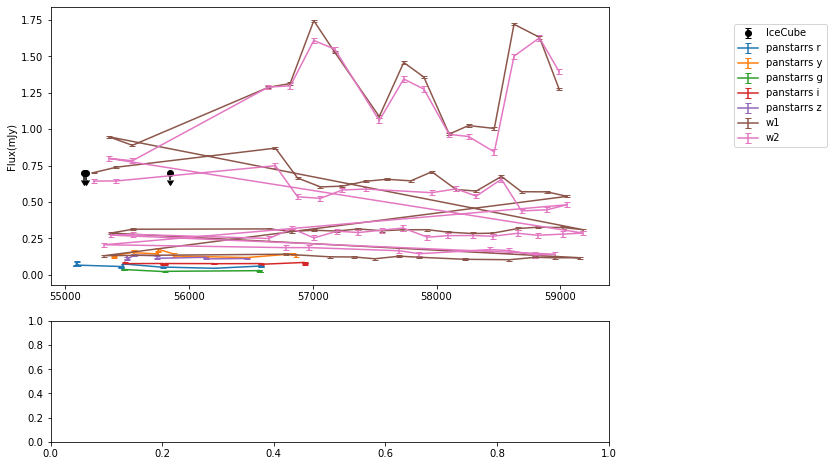

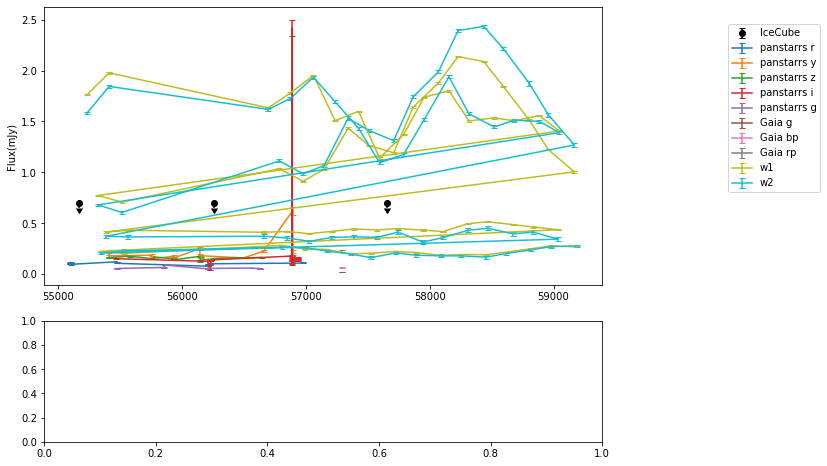

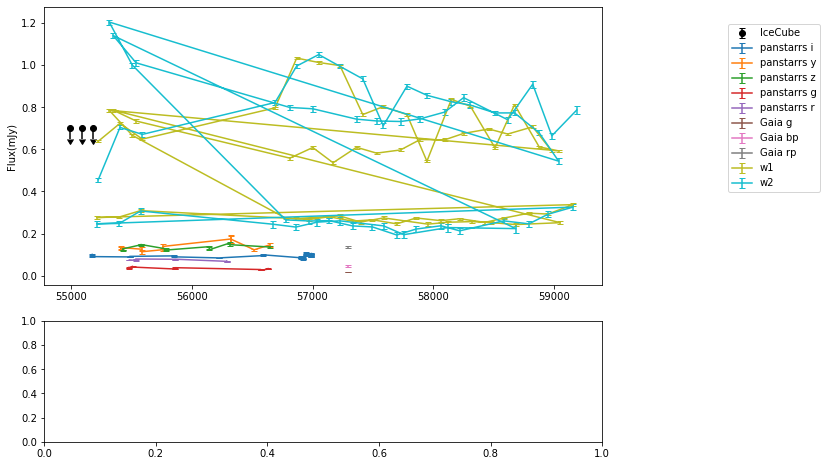

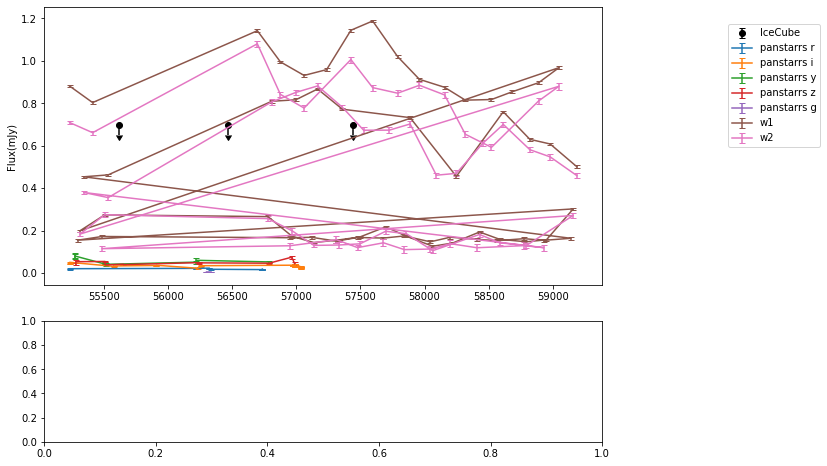

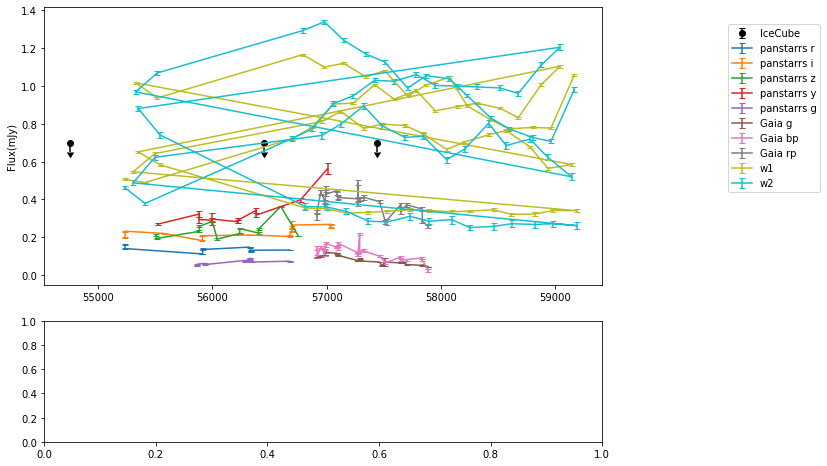

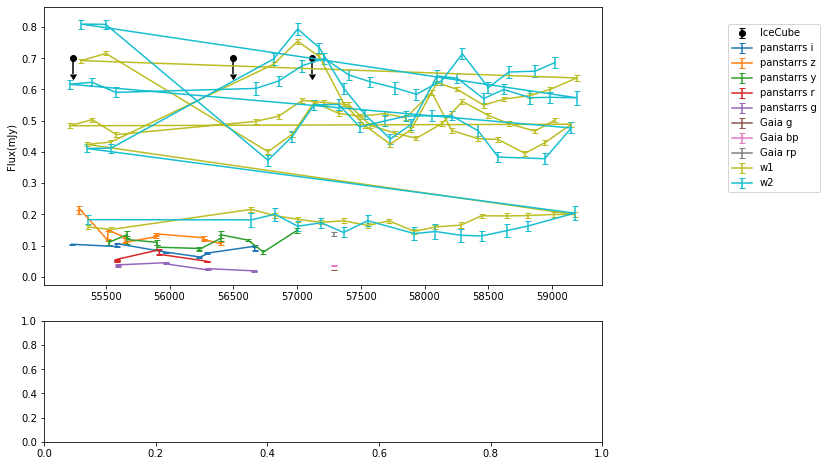

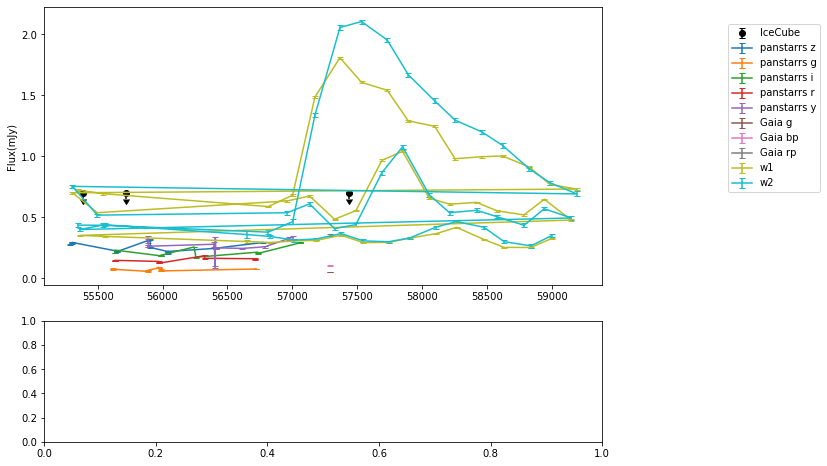

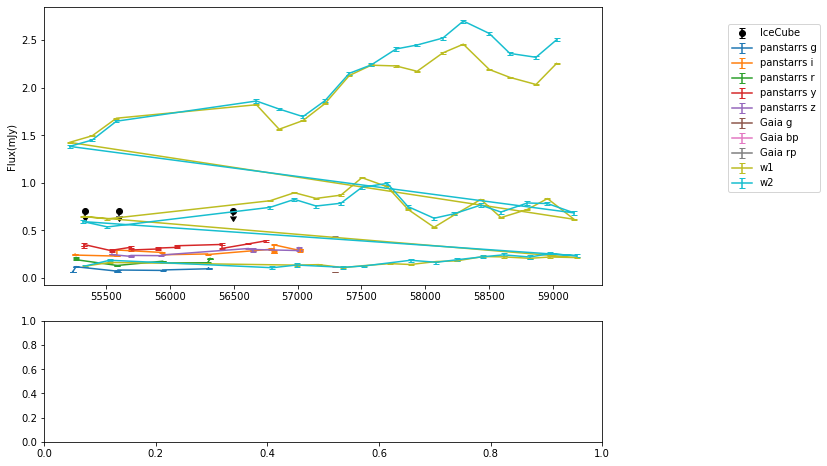

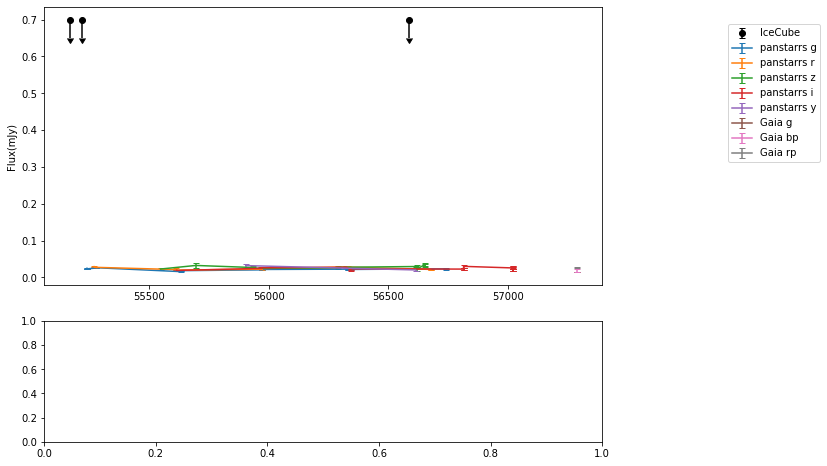

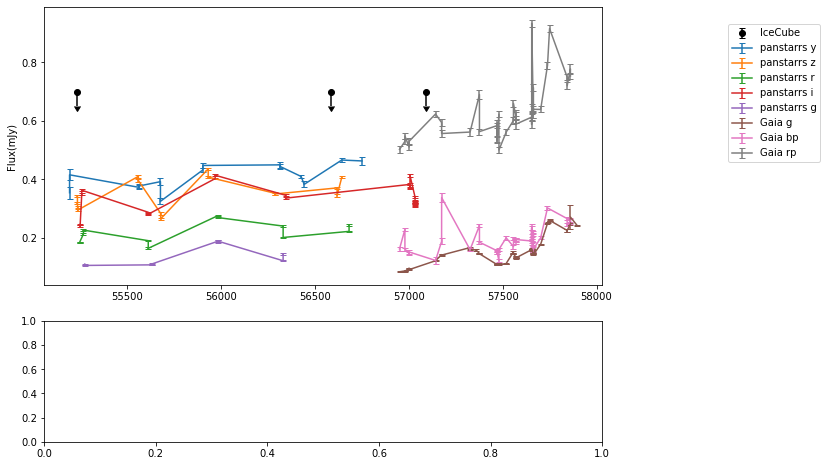

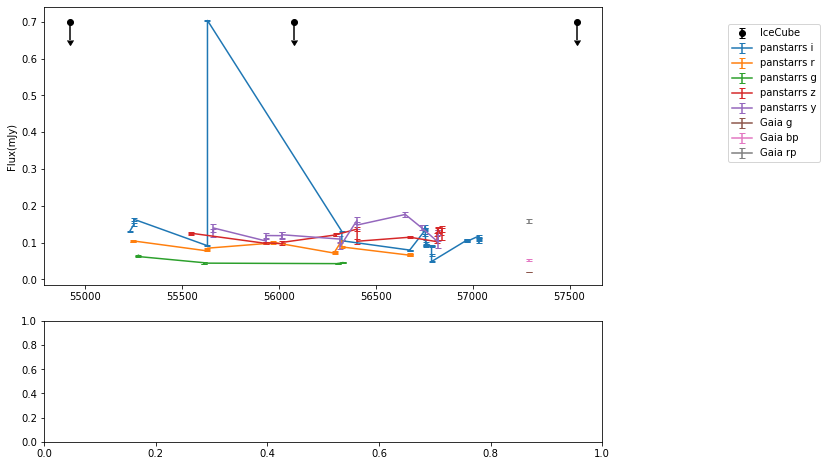

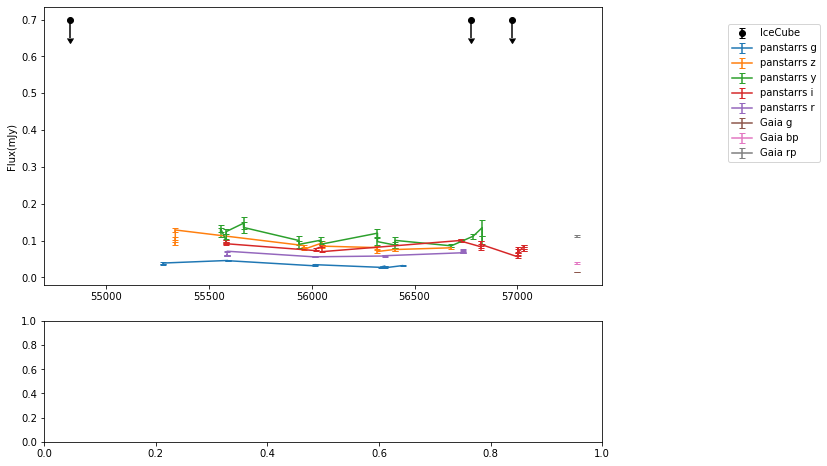

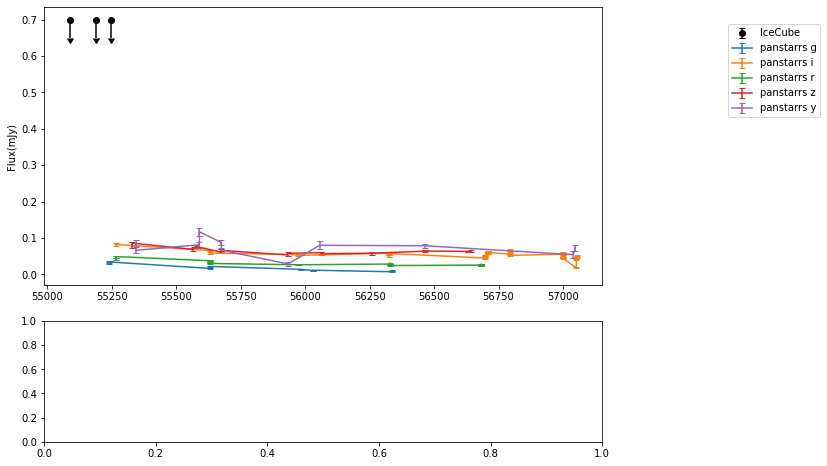

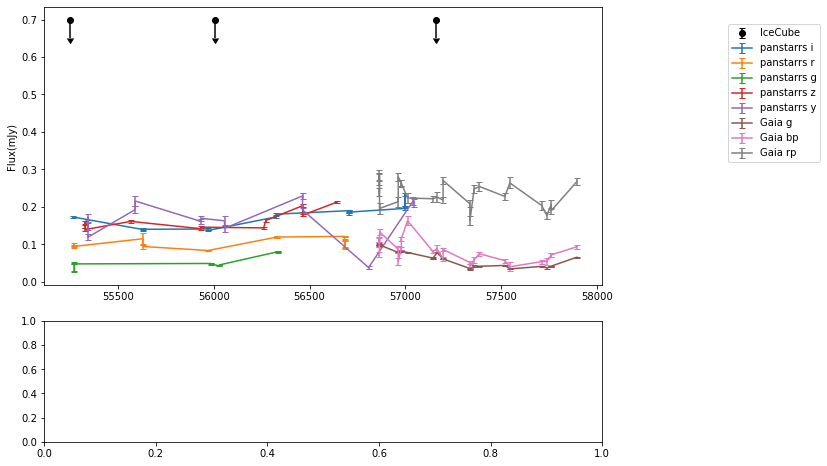

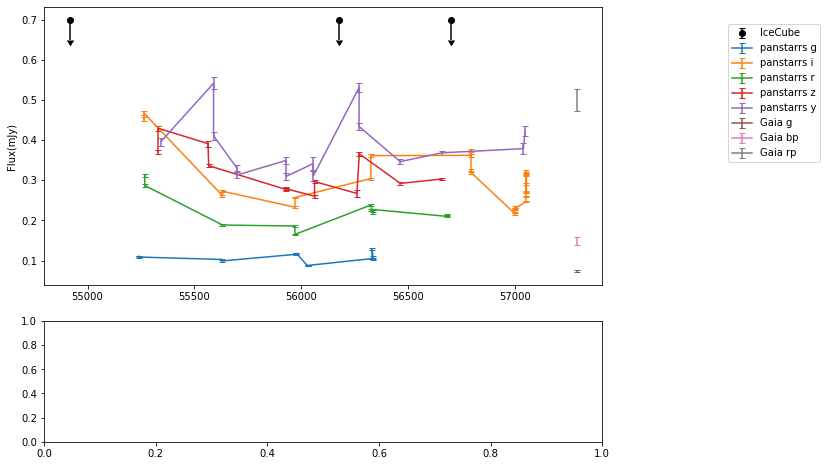

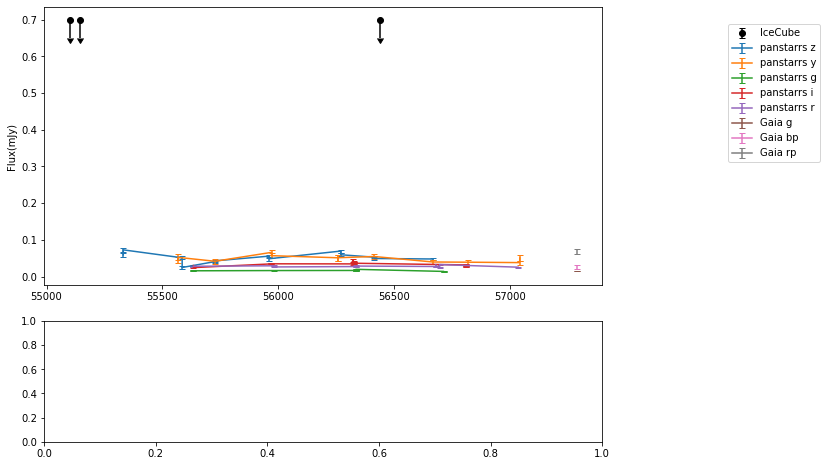

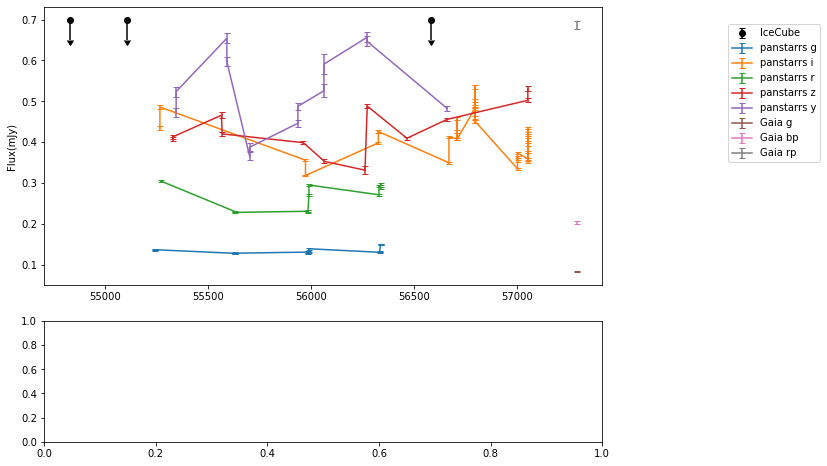

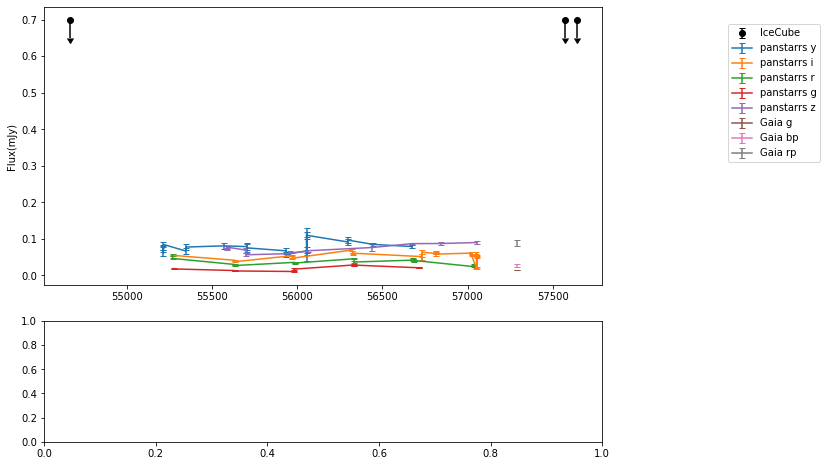

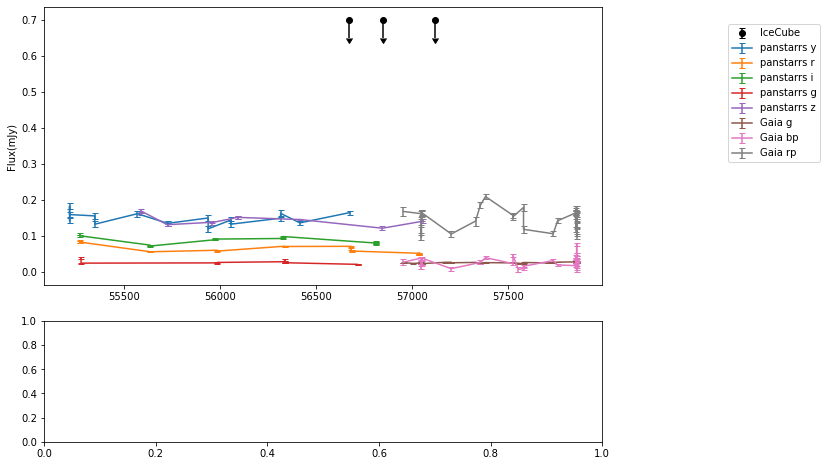

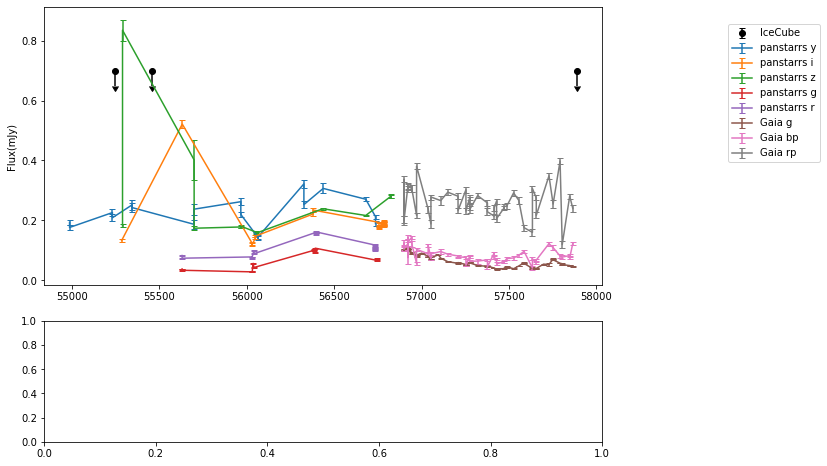

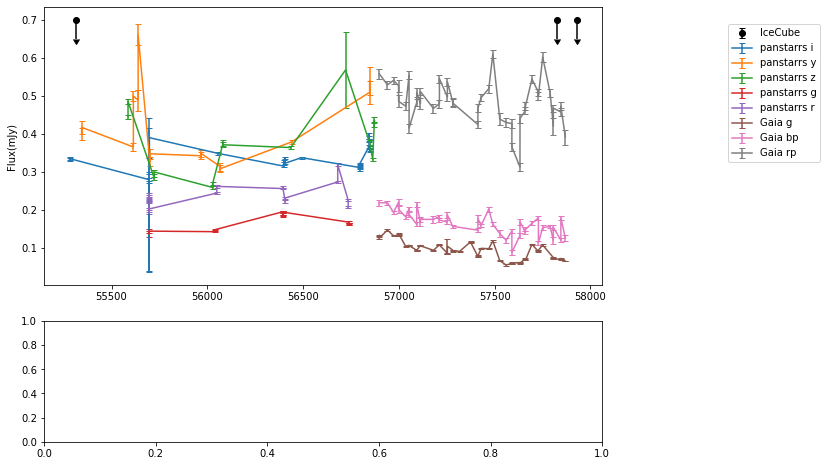

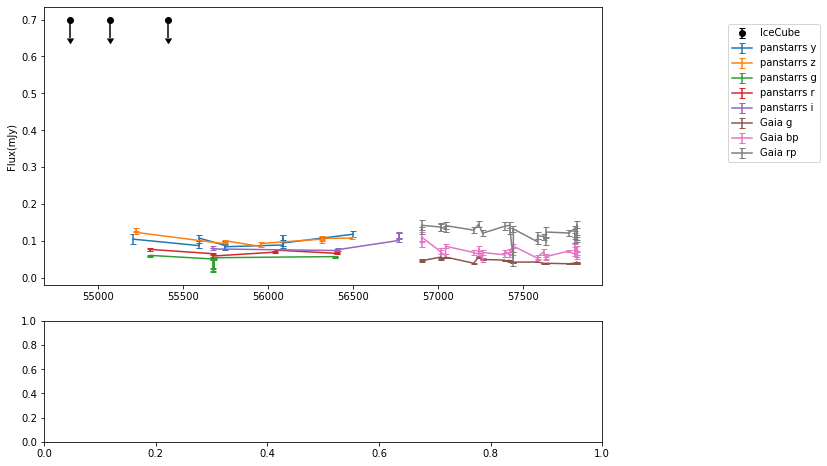

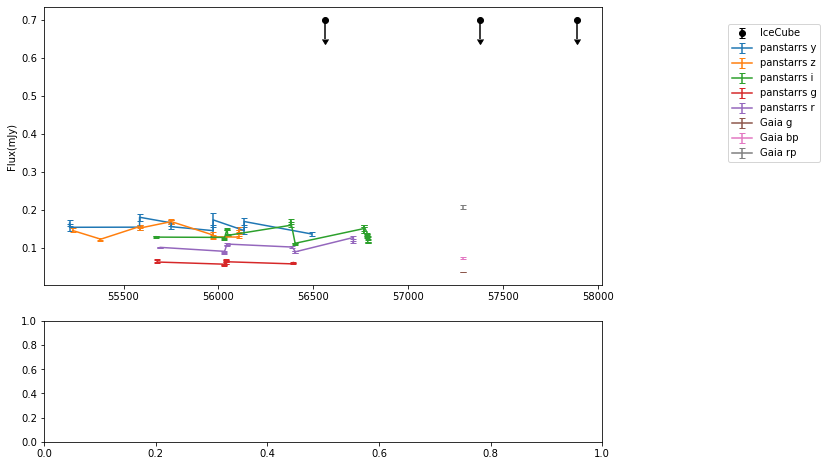

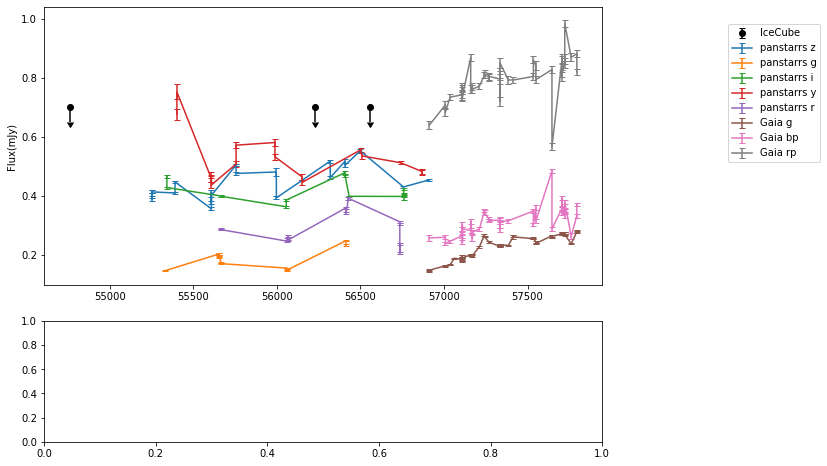

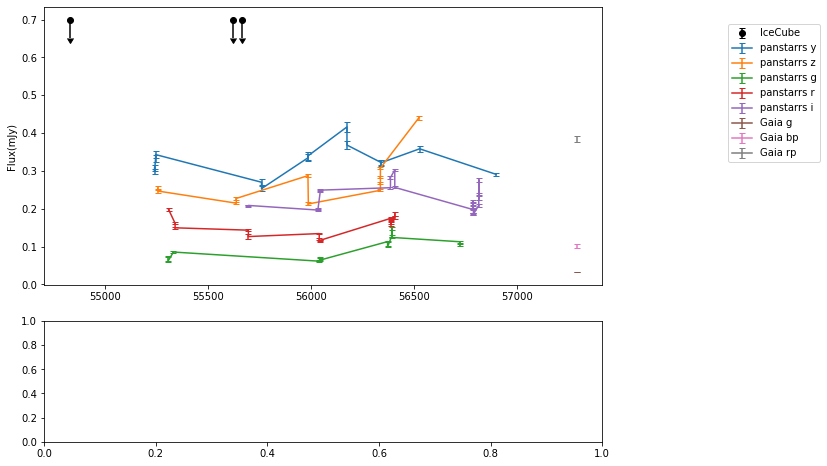

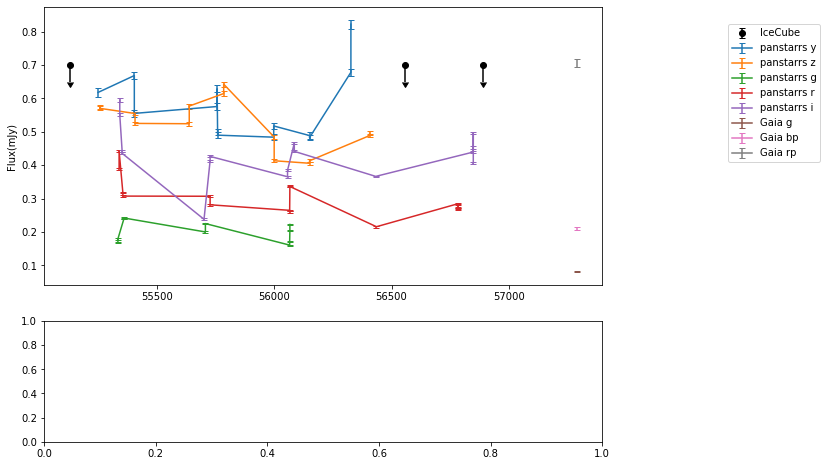

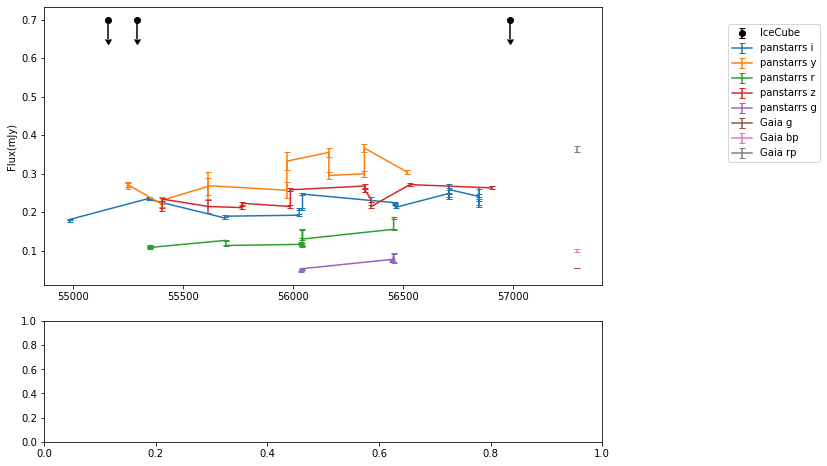

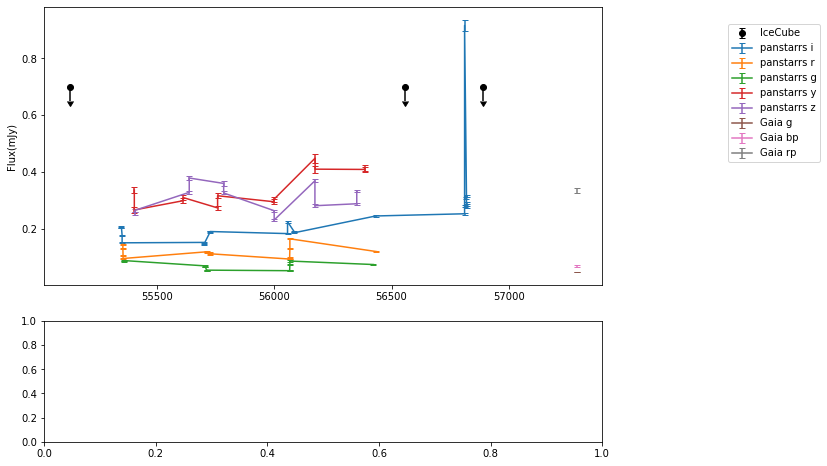

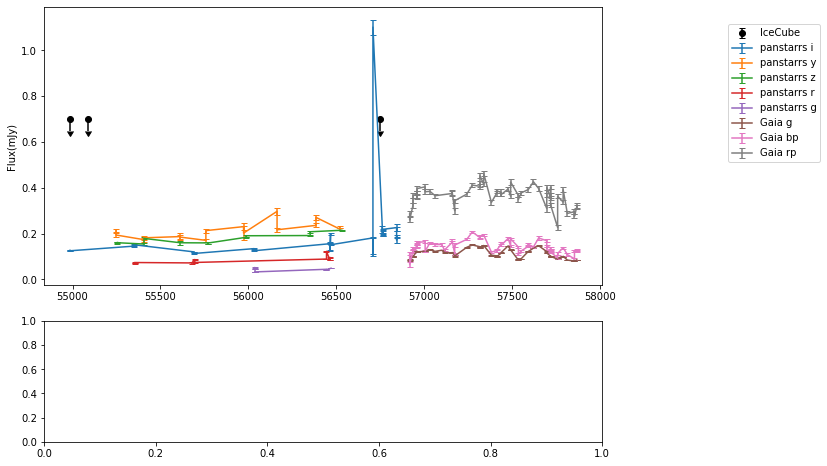

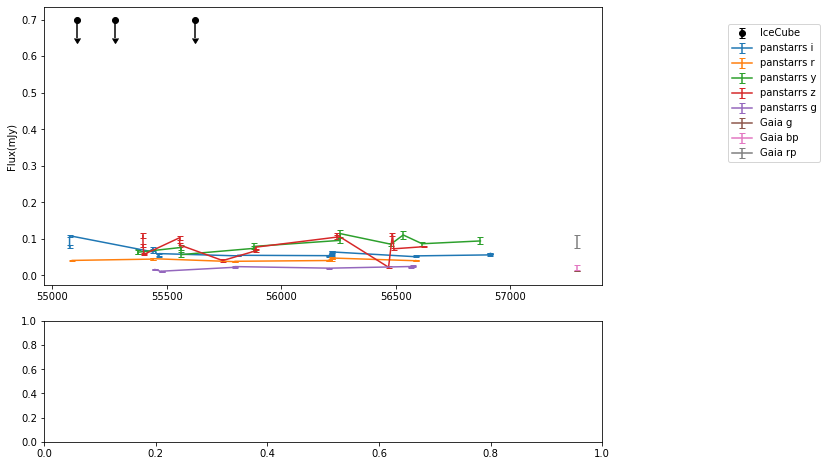

CPU times: user 37.8 s, sys: 9.53 s, total: 47.4 s
Wall time: 35.8 s


In [22]:
%%time

## NOTE: have to go in order such that the plots turn out correctly!!!!
# Would be easier to link with a (made-up) object name instead of number of row??
for ccount, coord in enumerate(coords_list):
    singleobj = df_lc.data.loc[(ccount+1),:,:]
    # Set up for plotting. We use the "mosaic" method so we can plot
    # the ZTF data in a subplot for better visibility.
    fig, axes = plt.subplot_mosaic(mosaic=[["A"],["A"],["B"]] , figsize=(10,8))
    plt.subplots_adjust(hspace=0.3 , wspace=0.3)

    # First check to see which bands we have in the dataframe
    availband = singleobj.index.unique('band')
    

    # Plot all the bands in the *main plot* (A)
    leg_handles_A = []
    max_list = [] # store maximum flux for each band
    ztf_minmax_tab = Table(names=["tmin","tmax","fluxmin","fluxmax"]) # store the min and max of the ZTF band fluxes and time
    has_ztf = False # flag to set to True if ZTF data is available.
    for l in range(len(availband)):
        band_lc = singleobj.loc[ccount+1,:, availband[l], :]
        #band_lc = singleobj.loc[: , availband[l] , :] # above line doesn't work for me [ALF]
        band_lc.reset_index(inplace = True)

        # first clean dataframe to remove erroneous rows
        band_lc_clean = band_lc[band_lc['time'] < 65000]
        
        #before plotting need to scale the Kepler, K2, and TESS fluxes to the other available fluxes
        if availband[l] in ['Kepler', 'K2', 'TESS']: # Note: these are not included anymore...
            #remove outliers in the dataset
            bandlc_clip = band_lc_clean[(np.abs(stats.zscore(band_lc_clean['flux'])) < 3.0)]

            #find the maximum value of 'other bands'
            max_electrons = max(band_lc_clean.flux)
            factor = np.mean(max_list)/ max_electrons
            lh = axes["A"].errorbar(bandlc_clip.time, bandlc_clip.flux * factor, bandlc_clip.err* factor,
                                    capsize = 3.0,label = availband[l])
        elif availband[l] in ['zg','zr','zi']: # for ZTF
            has_ztf = True
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5,marker='o',markersize=2,linestyle='', label = "ZTF {}".format(availband[l]))
            ztf_minmax_tab.add_row( [np.min(band_lc_clean.time) , np.max(band_lc_clean.time) , np.min(band_lc_clean.flux) , np.max(band_lc_clean.flux) ] )
            
            
            # plot ZTF in zoomin
            p1 = axes["B"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 1.0, elinewidth=0.5, marker='o',linestyle='',markersize=0.5, alpha=0.5,
                                    label = "ZTF {}".format(availband[l]))
            
            # overplot running mean fo ZTF in zoomin 
            xx = band_lc_clean.time
            yy = band_lc_clean.flux
            ee = band_lc_clean.err
            x_bin = 30 # in MJD
            x_grid = np.arange(np.nanmin(xx) , np.nanmax(xx)+x_bin/4 , x_bin/4)
            tmp = Table(names=["xbin","ybin","yerr"])
            for xxx in x_grid:
                s = np.where( np.abs(xx - xxx) < x_bin/2 )[0]
                if len(s) > 1:
                    mn = np.nansum(yy[s]*ee[s]) / np.nansum(ee[s]) # weighted mean
                    tmp.add_row([xxx , mn , np.nanstd(yy[s])])
                else:
                    #pass
                    tmp.add_row([xxx , np.nan , np.nan])
            axes["B"].plot(tmp["xbin"] , tmp["ybin"] , "-", linewidth=1.5 , color=p1.lines[0].get_color())
            
        elif availband[l] in ["IceCube"]: # IceCube (no fluxes, just events)
            y = axes["A"].get_ylim()[0] + np.diff(axes["A"].get_ylim())*0.7
            dy = np.diff(axes["A"].get_ylim())/20
            lh = axes["A"].errorbar(band_lc_clean.time , np.repeat(y , len(band_lc_clean.time)) , yerr=dy, uplims=True ,
                                    fmt="o"  , label=availband[l] , color="black")
            
        else: # everything else
            max_list.append(max(band_lc_clean.flux)) 
            lh = axes["A"].errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err,
                                    capsize = 3.0, label = availband[l])

        leg_handles_A.append(lh)
    
    # Plot the ZTF bands in a separate plot to show their variability
    # more clearly. Can still also plot the rest, just change the x and
    # y axis limits. Only do this if ZTF is available for source.

    ## Do Axes
    
    #axes["A"].spines['top'].set_visible(False)
    #axes["A"].spines['right'].set_visible(False)
    axes["A"].set_ylabel('Flux(mJy)')
    
    if has_ztf:
        axes["B"].set_ylabel('Flux(mJy)')
        axes["B"].set_xlabel('Time(MJD)')

        axes["B"].set_xlim( np.min(ztf_minmax_tab["tmin"])-100 , np.max(ztf_minmax_tab["tmax"])+100 )
    
    
    plt.legend(handles=leg_handles_A , bbox_to_anchor=(1.4,3.5))
    plt.tight_layout()
    #save the plot to data/*.pdf
    savename = "data/lightcurve_{}.pdf".format(ccount+1)
    plt.savefig(savename, bbox_inches="tight")
    plt.show()
    


## References

This work made use of:

- Astroquery; Ginsburg et al., 2019, 2019AJ....157...98G

- Astropy; Astropy Collaboration 2022, Astropy Collaboration 2018, Astropy Collaboration 2013, 2022ApJ...935..167A, 2018AJ....156..123A, 2013A&A...558A..33A

- Lightkurve; Lightkurve Collaboration 2018, 2018ascl.soft12013L

- acstools; https://zenodo.org/record/7406933#.ZBH1HS-B0eY

- unTimely; Meisner et al., 2023, 2023AJ....165...36M

- Alerce; Forster et al., 2021, 2021AJ....161..242F